# Porównanie działania wielomodalnego autoenkodera i wielomodalnego wariacyjnego autoenkodera w zadaniu klasyfikacji
## Mateusz Kochanek i Igor Cichecki

## Importy

In [1]:
from typing import Dict, List, Type

import pandas as pd
import torch
from sklearn.decomposition import PCA
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.loggers import TensorBoardLogger
import pytorch_lightning as pl
from abc import abstractmethod
import os
from plotly import express as px
from src.dataset import MyDataset, DataModule
from src.multimodal_ae import (
    MultimodalEncoder,
    AvgFusion,
    MLPFusion,
    MultimodalDecoder,
    BaseAE,
    MultimodalAE,
)
from src.multimodal_vae import (
    Swish,
    Encoder,
    Decoder,
    ProductOfExperts,
    BaseVAE,
    MVAE,
)
from src.utils import (
    extract_multimodal_ae_embeddings,
    extract_multimodal_vae_embeddings,
    visualize_most_similar,
    make_interactive_scatter_plot,
)
from src.train import train_model

Found cached dataset cc6204-hackaton-cub-dataset (/home/erthax/.cache/huggingface/datasets/alkzar90___cc6204-hackaton-cub-dataset/default/0.0.0/de850c9086bff0dd6d6eab90f79346241178f65e1a016a50eec240ae9cdf2064)


  0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
import plotly.io as pio
pio.renderers.default='notebook'

## Stałe do badań

In [3]:
CUBE_N_CLASSES = 200
MEME_N_CLASSES = 2
IMG_REPREZENTATION_SIZE = 2048
TEXT_REPREZENTATION_SIZE = 384
N_TESTS = 5

## Opis problemu:
- Jako danych wejściowych do przetestowania autoenkoderów użyto dwóch zbiorów danych [CUB-200-2011](https://huggingface.co/datasets/alkzar90/CC6204-Hackaton-Cub-Dataset), [Hatefull Meme dataset](https://www.kaggle.com/datasets/parthplc/facebook-hateful-meme-dataset?resource=download). W zbiorze CUB podzielono opisy obrazków tak aby jedno zdanie było jednym opisem i dodano je z razem z odpowiadającymi obrazkami zbioru (te same obrazki występują kilkakrotnie). Samo przygotowanie datasetów przeprowadzono w notebooku `prepare_datasets.ipynb`. Jako zbioru do klasyfikacji użyto zbioru Hatefull Meme dataset, bo zbiór Cub ma bardzo dużo klas z małą ilością przykładów, więc jest trudny do klasyfikacji. Oba zbiory przetworzono w ten sam sposób, generując osadzenia obrazków za pomocą sieci `resnet-50`, a osadzenia tekstów używając `SentenceTransformer("all-MiniLM-L6-v2")`.
- Wyuczone reprezentacje zostaną użyte w problemie binarnej klasyfikacji na zbiorze danych Hatefull Meme.
- Spodziewano się, że w zadaniu klasyfikacji binarnej autoenkoder wariacyjny osiągnie gorsze wyniki niż standardowy autoenkoder.

### Zbiory danych

#### CUB
- img_emb
- text_emb
- text

In [4]:
cube_datamodule = DataModule(
    train_path="data/cub/preprocessed_train.pkl",
    test_path="data/cub/preprocessed_test.pkl",
    batch_size=64,
)

In [5]:
cube_df = cube_datamodule.df["all"]

In [6]:
cube_df.head()

index                                            img_emb  \
0      0  [tensor(0.0175, device='cuda:0'), tensor(0.000...   
1      1  [tensor(0.0175, device='cuda:0'), tensor(0.000...   
2      2  [tensor(0.0175, device='cuda:0'), tensor(0.000...   
3      3  [tensor(0.0175, device='cuda:0'), tensor(0.000...   
4      4  [tensor(0.0175, device='cuda:0'), tensor(0.000...   

                                            text_emb  image_index  \
0  [tensor(0.0832, device='cuda:0'), tensor(0.064...            0   
1  [tensor(0.0553, device='cuda:0'), tensor(0.112...            0   
2  [tensor(0.1281, device='cuda:0'), tensor(0.023...            0   
3  [tensor(0.0782, device='cuda:0'), tensor(0.077...            0   
4  [tensor(0.0802, device='cuda:0'), tensor(0.090...            0   

                                                text  label  
0     this bird is brown with a lighter brown crest.      0  
1  aquatic large bird with long hooked bill, whit...      0  
2  bird has brown body feathers, brown breast fea...      0  
3  this bird has a white superciliary and brown a...      0  
4  this is a brown bird with a white face and a l...      0

#### Hatefull Meme
- img_emb
- text_emb
- text

In [7]:
meme_datamodule = DataModule(
    train_path="data/heatfull_meme/preprocessed_train.pkl",
    test_path="data/heatfull_meme/preprocessed_test.pkl",
    batch_size=64,
)

In [8]:
meme_df = meme_datamodule.df["all"]

In [9]:
meme_df.head()

index                                            img_emb  \
0      0  [tensor(0.0131, device='cuda:0'), tensor(0.004...   
1      1  [tensor(0.0182, device='cuda:0'), tensor(0.000...   
2      2  [tensor(0.0181, device='cuda:0'), tensor(0.000...   
3      3  [tensor(0.0167, device='cuda:0'), tensor(0.000...   
4      4  [tensor(0.0119, device='cuda:0'), tensor(0.007...   

                                            text_emb  image_index  \
0  [tensor(0.0594, device='cuda:0'), tensor(0.036...        42953   
1  [tensor(-0.0044, device='cuda:0'), tensor(-0.1...        23058   
2  [tensor(0.0626, device='cuda:0'), tensor(-0.01...        13894   
3  [tensor(-0.0007, device='cuda:0'), tensor(0.01...        37408   
4  [tensor(-0.0062, device='cuda:0'), tensor(0.02...        82403   

                                                text  label  
0   its their character not their color that matters      0  
1  don't be afraid to love again everyone is not ...      0  
2                           putting bows on your pet      0  
3  i love everything and everybody! except for sq...      0  
4  everybody loves chocolate chip cookies, even h...      0

## Opisy wybranych modeli:

**Wielomodalny Autoenkoder**
- Użyto autoencodera o podobnej strukturze jak ten omawiany na liście.
- Model ma po jednym koderze i dekoderze dla każdej modalności. Autoenkoder za pomocą koderów przekształca te dane z różnych modalności w reprezentacje, które łączy za pomocą odpowiedznio zdefiniowanej fuzji. Następnie dekodery starają się odbudować daną modalność z uzyskanej wcześniej reprezentacji. Celem jest jak najlepsze odbudowanie danych wejściowych.
    - Dodatkowo reprezentacji użyto jako wejścia do prostego klasyfikatora, aby zobaczyć jak dobrze autoenkoder modeluje dane wejściowe.
- Metoda bazuje na standardowym autoenkoderze. Rozszerza go tutaj o dodatkowe kodery/dekodery dla kolejnych modalności, a także o sposób łączenia ze sobą reprezentacji z koderów.

**Wielomodalny Wariacyjny Autoenkoder**
- [Multimodal Generative Models for Scalable Weakly-Supervised Learning](https://arxiv.org/abs/1802.05335)
- Metoda bazuje na standardowym wielomodalnym autoenkoderze. Główną różnicą jest to, że wyjściem z koderów nie jest reprezentacja, a średnie i odchylenia standardowe rozkładów normalnych, które są ze sobą łączone za pomocą [Product of Experts](https://arxiv.org/pdf/1410.7827.pdf), i z nich bezpośrednio próbkowane są reprezentcje. Jest to również jeden z pierwszych zaproponowanych modeli wariacyjnych, które starają radzić sobie z brakiem jednej z modalności.
    - Tutaj również ostatczenie użyto reprezentacji jako wejścia do prostego klasyfikatora, aby zobaczyć jak dobrze autoenkoder modeluje rozkład danych wejściowych.


![alt text](MVAE.png "Title")

**Baseline - Wileomodalny MLP**
- Wyciągnięcie orginalnych osadzeń obrazka i tekstu, i nadzorowanie wyuczenie na nich klasyfikacji.

### Analiza reprezentacji wielomodalnego autokodera dla domyślnych hiperparametrów

In [10]:
default_mae_hparams = {
    "encoder_cls": MultimodalEncoder,
    "modality_names": ["img_emb", "text_emb"],
    "data_dims": {"img_emb": 2048, "text_emb": 384}, 
    "batch_size": 64,
    "num_epochs": 5,
    "hidden_dims": [256, 256, 256],
    "emb_dim": 128,
    "lr": 1e-3,
    "weight_decay": 5e-4,
}

### Trening

In [11]:
train_model(
    model_cls=MultimodalAE,
    hparams={
        "name": "CubeImageTextAvgAE",
        "fusion": "Avg",
        **default_mae_hparams,
    },
    datamodule=cube_datamodule,
)

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning:

Checkpoint directory /home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/CubeImageTextAvgAE exists and is not empty.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | encoder | MultimodalEncoder | 952 K 
1 | decoder | MultimodalDecoder | 954 K 
2 | fusion  | AvgFusion         | 0     
----------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.625     Total estimated model params size (MB)
/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/pytorch_lightn

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:231: UserWarning:

You called `self.log('step', ...)` in your `validation_epoch_end` but the value needs to be floating point. Converting it to torch.float32.

/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:231: UserWarning:

You called `self.log('step', ...)` in your `training_epoch_end` but the value needs to be floating point. Converting it to torch.float32.

Epoch 0, global step 0: 'val/loss' reached 0.00009 (best 0.00009), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/CubeImageTextAvgAE/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 1: 'val/loss' reached 0.00006 (best 0.00006), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/CubeImageTextAvgAE/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 2: 'val/loss' reached 0.00005 (best 0.00005), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/CubeImageTextAvgAE/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 3: 'val/loss' reached 0.00004 (best 0.00004), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/CubeImageTextAvgAE/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 4: 'val/loss' reached 0.00004 (best 0.00004), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/CubeImageTextAvgAE/model-v2.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


In [12]:
train_model(
    model_cls=MultimodalAE,
    hparams={
        "name": "MemeImageTextAvgAE",
        "fusion": "Avg",
        **default_mae_hparams,
    },
    datamodule=meme_datamodule,
)

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning:

Checkpoint directory /home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/MemeImageTextAvgAE exists and is not empty.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | encoder | MultimodalEncoder | 952 K 
1 | decoder | MultimodalDecoder | 954 K 
2 | fusion  | AvgFusion         | 0     
----------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.625     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 0: 'val/loss' reached 0.00048 (best 0.00048), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/MemeImageTextAvgAE/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 1: 'val/loss' reached 0.00045 (best 0.00045), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/MemeImageTextAvgAE/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 2: 'val/loss' reached 0.00042 (best 0.00042), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/MemeImageTextAvgAE/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 3: 'val/loss' reached 0.00040 (best 0.00040), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/MemeImageTextAvgAE/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 4: 'val/loss' reached 0.00038 (best 0.00038), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/MemeImageTextAvgAE/model-v2.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


### Ekstrakcja wektorów osadzeń

In [13]:
cube_z = extract_multimodal_ae_embeddings(
    MultimodalAE,
    datamodule=cube_datamodule,
    name="CubeImageTextAvgAE",
)

In [14]:
meme_z = extract_multimodal_ae_embeddings(
    MultimodalAE,
    datamodule=meme_datamodule,
    name="MemeImageTextAvgAE",
)

### Wizualizacja

Anchor: anne frank writing in her diary
7841: anne frank smiling
4798: this is anne frank in june 1929
4506: survives ebola gets adopted by angelina jolie
6394: diary of a wimpy kid hard luck anne frank is one wimpy kid
2509: feminist literature? you mean cookbooks?


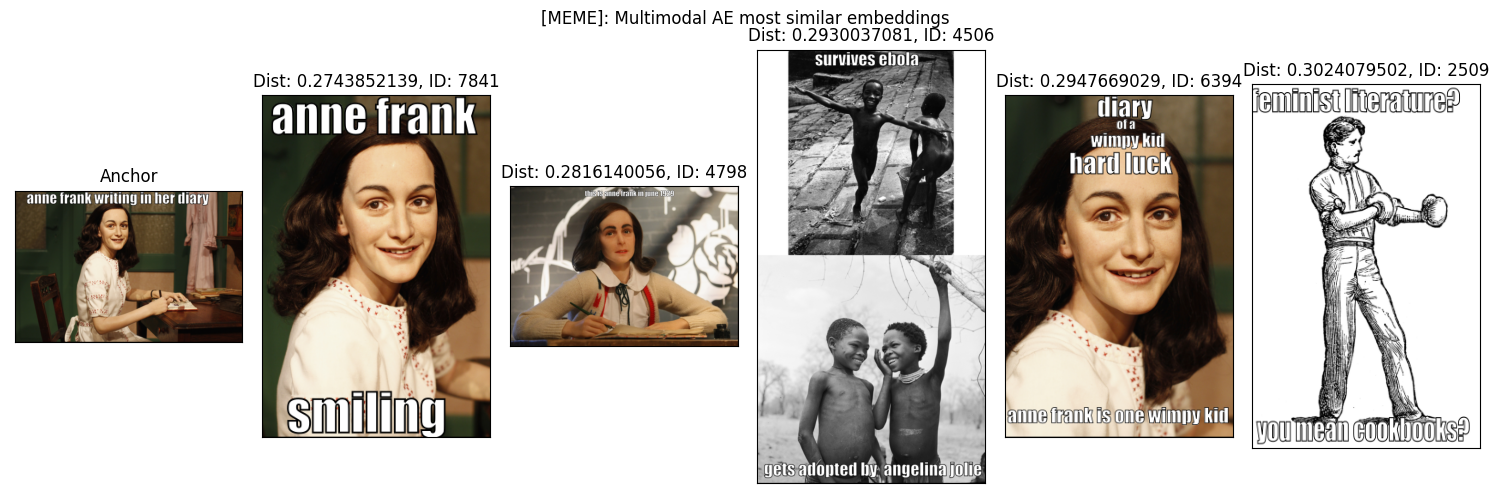

In [15]:
_ = visualize_most_similar(
    df=meme_df,
    title="[MEME]: Multimodal AE most similar embeddings",
    anchor_index=200,
    z=meme_z.cpu(),
    dataset="hatefull",
)

Anchor: a black bird with a grey belly and a white stripe on the tip of it's cheek pattern also has short, orange bill.
1889: a dark grey bird with white underparts, a white stripe on its head and a short, orange bill.
88482: the bird has black and grey coverts with a very long and slender orange bill.
36308: this bird has a short pointed orange bill, with a black crown and grey belly.
93304: grey and brown bird with short black bill and white on cheeks
42825: this bird has a long pointed bill black at the end and orange toward the throat, black crown with white under crown. grey white wing and orange thigh and foot.


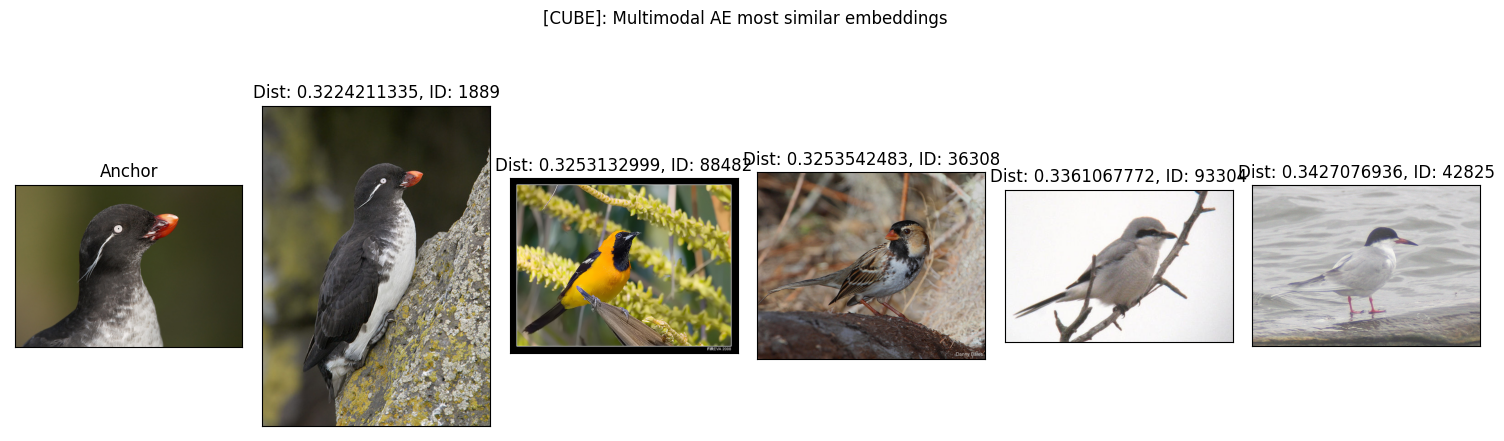

In [16]:
_ = visualize_most_similar(
    df=cube_df,
    title="[CUBE]: Multimodal AE most similar embeddings",
    anchor_index=2001,
    z=cube_z.cpu(),
)

In [17]:
make_interactive_scatter_plot(
    title="Multimodal embeddings (Avg)",
    z_2d=PCA(n_components=2).fit_transform(meme_z.cpu()),
    df=meme_datamodule.df["all"],
    port=8061
)

## Analiza reprezentacji wielomodalnego  wariacyjnego autokodera dla domyślnych hiperparametrów

In [18]:
default_mvae_hparams = {
    "data_dims": {"image": 2048, "text": 384}, 
    "batch_size": 64,
    "num_epochs": 3,
    "hidden_dims": {
        "image": [1024, 512, 256],#lst[::-1]
        "text": [256, 256, 256],
    },
    "emb_dim": 128,
    "lr": 1e-4,
    "weight_decay": 5e-4,
}

### Trening

In [19]:
train_model(
    model_cls=MVAE,
    hparams={
        "name": "CubeImageTextVAE",
        "activation" : Swish,
        "lambda_image" : 1.0,
        "lambda_text" : 1.0,
        "annealing_factor" : 1.0,
        **default_mvae_hparams,
    },
    datamodule=cube_datamodule,
)

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning:

Checkpoint directory /home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/CubeImageTextVAE exists and is not empty.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type             | Params
--------------------------------------------------------
0 | image_encoder      | Encoder          | 2.8 M 
1 | image_decoder      | Decoder          | 2.8 M 
2 | text_encoder       | Encoder          | 295 K 
3 | text_decoder       | Decoder          | 263 K 
4 | product_of_experts | ProductOfExperts | 0     
--------------------------------------------------------
6.2 M     Trainable params
0         Non-trainable params
6.2 M  

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 0: 'val/loss' reached 0.00398 (best 0.00398), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/CubeImageTextVAE/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 1: 'val/loss' reached 0.00240 (best 0.00240), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/CubeImageTextVAE/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 2: 'val/loss' reached 0.00210 (best 0.00210), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/CubeImageTextVAE/model-v2.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=3` reached.


In [20]:
train_model(
    model_cls=MVAE,
    hparams={
        "name": "MemeImageTextVAE",
        "activation" : Swish,
        "lambda_image" : 1.0,
        "lambda_text" : 1.0,
        "annealing_factor" : 1.0,
        **default_mvae_hparams,
    },
    datamodule=meme_datamodule,
)

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning:

Checkpoint directory /home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/MemeImageTextVAE exists and is not empty.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type             | Params
--------------------------------------------------------
0 | image_encoder      | Encoder          | 2.8 M 
1 | image_decoder      | Decoder          | 2.8 M 
2 | text_encoder       | Encoder          | 295 K 
3 | text_decoder       | Decoder          | 263 K 
4 | product_of_experts | ProductOfExperts | 0     
--------------------------------------------------------
6.2 M     Trainable params
0         Non-trainable params
6.2 M  

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 0: 'val/loss' reached 2.02957 (best 2.02957), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/MemeImageTextVAE/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 1: 'val/loss' reached 0.14564 (best 0.14564), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/MemeImageTextVAE/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 2: 'val/loss' reached 0.07126 (best 0.07126), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/MemeImageTextVAE/model-v2.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=3` reached.


### Ekstrakcja wektorów osadzeń

In [21]:
cube_z = extract_multimodal_vae_embeddings(
    MVAE,
    datamodule=cube_datamodule,
    name="CubeImageTextVAE",
)

In [22]:
meme_z = extract_multimodal_vae_embeddings(
    MVAE,
    datamodule=meme_datamodule,
    name="MemeImageTextVAE",
)

### Wizualizacja

Anchor: anne frank writing in her diary
1363: what's the difference between jews and a loaf of bread? a loaf of bread doesn't burn in an oven
1219: a local market
1718: ancestry.com the results are in
304: you don't need an ar15 to protect yourself but he does, and this guy and this guy, and him and him and him
1360: if you got your phone wet try leaving it in dry rice overnight it will attract asians who will fix your electronics for you


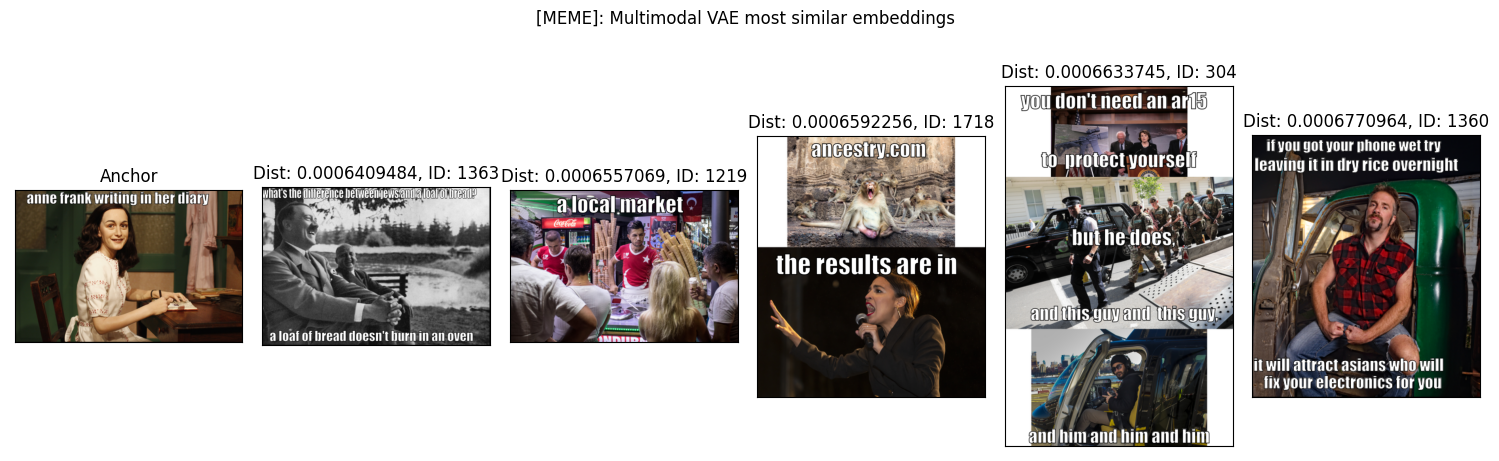

In [23]:
_ = visualize_most_similar(
    df=meme_df,
    title="[MEME]: Multimodal VAE most similar embeddings",
    anchor_index=200,
    z=meme_z.cpu(),
    dataset="hatefull",
)

Anchor: a black bird with a grey belly and a white stripe on the tip of it's cheek pattern also has short, orange bill.
10194: bird with sharp and pointed beak that is gray, and brown tarsus and feet, and white belly and abdomen
16837: bird has black head and wings with a light colored beak, white abdomen and distinctive bright red patch on its chest.
102410: a very round bird that is grey with some yellow in it's wing, a red crown, and a short pointy beak.
19615: a medium sized bird with a grey head and neck. its breast is white and the wings are all grey, with the exception of the tips of the primaries, which are white. it has a yellow bill with a red spot on the bottom of the tip.
21271: the bird has a white belly with large black wings and a grey crown with a curved grey beak.


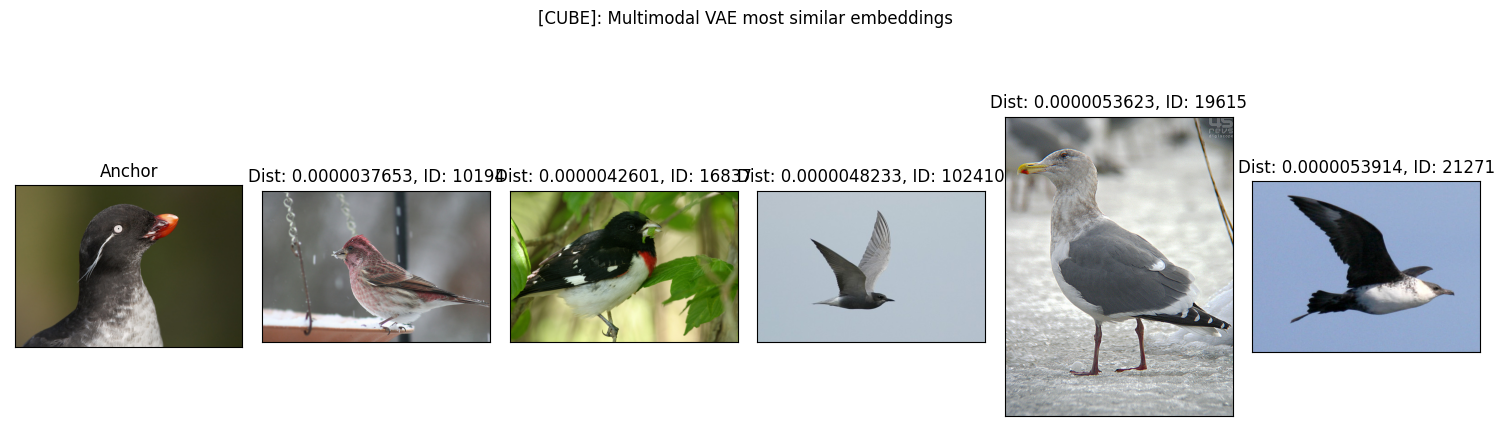

In [24]:
_ = visualize_most_similar(
    df=cube_df,
    title="[CUBE]: Multimodal VAE most similar embeddings",
    anchor_index=2001,
    z=cube_z.cpu(),
)

In [25]:
make_interactive_scatter_plot(
    title="Multimodal embeddings VAE",
    z_2d=PCA(n_components=2).fit_transform(meme_z.cpu()),
    df=meme_datamodule.df["all"],
    port=8062
)

**KOMENTARZ**:
* Dla zbioru `hatefull_meme` możemy zaobserwować że dla wielomodalnego autokodera podobne obrazy przekładają się na "bliskie" wektory reprezentacji.
* W przypadku wielomodalnego wariacyjnego autokodera ciężko mówić o podobnej zależności.

## Eksperymenty

W trakcie eksperymentów sprawdzano najlepsze parametry dla każdego z modeli. Następnie dla każdego modelu kilkukrotnie uruchomiono model z najlepszymi parametrami. Po każdym eksperymencie dla danego parametru wyświetlono tabelę z wynikami, w podsumowaniu zwawarto tabelę finałowego eksperymentu na najlepszych parametrzach.
- Do klasyfikacji wybrano zbiór `hatefull_meme`.
- Do analizy modeli zastosowano metryki F1Score i Accuracy.
- Przeprowadzono badania wielkości reprezentacji i ilości/wielkości warstw głębokich w MVAE i MAE.
- Stworzono podstawowy baseline, ale w podsumowaniu omówiono również wyniki z pracy nad zbiorem.

### Klasyfikacja - Kod modelu

In [61]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [27]:
LOG_DIR = './logs/'
os.makedirs(LOG_DIR, exist_ok=True)
LOAD_LOGS = LOG_DIR + "lightning_logs/"

In [28]:
import torchmetrics


class Classifier(pl.LightningModule):

    def __init__(
        self,
        model: pl.LightningModule,
        lr: float,
        n_classes: int,
    ) -> None:
        super().__init__()
        self.loss = torch.nn.CrossEntropyLoss()
        self.lr = lr
        self.model = model
        self.f1score = torchmetrics.classification.F1Score(type="binary", average="macro", num_classes=2)
        self.accuracy = torchmetrics.classification.BinaryAccuracy()

    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def predict_step(self, train_batch, batch_idx):
        x = train_batch
        return self(x), x["label"]
    
    def training_step(self, train_batch, batch_idx):
        x = train_batch
        y = x["label"]
        y_hat = self(x)
        y_pred = y_hat.argmax(dim=1)
        loss = self.loss(y_hat, y)
        metrics = {
            'loss/train': loss,
            "f1score/train": self.f1score(y_pred, y),
            "accuracy/train": self.accuracy(y_pred, y),
        }
        self.log_dict(metrics, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x = val_batch
        y = x["label"]
        y_hat = self(x)
        y_pred = y_hat.argmax(dim=1)
        loss = self.loss(y_hat, y)
        metrics = {
            'loss/val': loss,
            "f1score/val": self.f1score(y_pred, y),
            "accuracy/val": self.accuracy(y_pred, y),
        }
        self.log_dict(metrics, on_step=True, on_epoch=True)
        return loss

    def test_step(self, test_batch, batch_idx):
        x = test_batch
        y = x["label"]
        y_hat = self(x)
        y_pred = y_hat.argmax(dim=1)
        loss = self.loss(y_hat, y)
        metrics = {
            'loss/test': loss,
            "f1score/test": self.f1score(y_pred, y),
            "accuracy/test": self.accuracy(y_pred, y),
        }
        self.log_dict(metrics, on_step=True, on_epoch=True)
        return loss

In [29]:
from itertools import pairwise


class ModalityMlp(pl.LightningModule):
    def __init__(
        self, 
        lr: float,
        input_size: int,
        hidden_sizes: list[int],
        n_classes: int,
        modality: str = "both",
    ):
        super().__init__()
        assert len(hidden_sizes) > 0
        self.modality = modality
        self.model = torch.nn.Sequential()
        for index, (first_size, second_size) in enumerate(pairwise([input_size, *hidden_sizes])):
            self.model.add_module(f"linear_{index}" , nn.Linear(first_size, second_size))
            self.model.add_module(f"relu_{index}", torch.nn.ReLU())
        self.model.add_module("head" , nn.Linear(hidden_sizes[-1], n_classes))
        self.model.add_module("softmax", nn.Softmax())

    def forward(self, x):
        if self.modality == "img":
            return self.model(x["img_emb"])
        elif self.modality == "text":
            return self.model(x["text_emb"])
        else:
            embedding = torch.cat((x["img_emb"],x["text_emb"]), dim=1)
            return self.model(embedding)

In [30]:
class AutoencoderMlp(pl.LightningModule):
    def __init__(
        self,
        autoencoder,
        lr: float,
        input_size: int,
        hidden_sizes: list[int],
        n_classes: int,
    ):
        super().__init__()
        assert len(hidden_sizes) > 0
        # Freeze autoencoder
        for param in autoencoder.parameters():
            param.requires_grad = False
        self.autoencoder = autoencoder
        self.model = torch.nn.Sequential()
        for index, (first_size, second_size) in enumerate(pairwise([input_size, *hidden_sizes])):
            self.model.add_module(f"linear_{index}" , nn.Linear(first_size, second_size))
            self.model.add_module(f"relu_{index}", torch.nn.ReLU())
        self.model.add_module("head" , nn.Linear(hidden_sizes[-1], n_classes))
        self.model.add_module("softmax" , nn.Softmax(dim=1))

    def forward(self, x):
        z = self.autoencoder.encode(x)
        return self.model(z)

### Przegląd parametrów dla Klasyfikatoa MLP nauczony na orginalnych osadzeniach

#### Learning Rate

In [31]:
metrics = []
for lr in [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2]:
    classifier = Classifier(
        model=ModalityMlp(
            input_size=IMG_REPREZENTATION_SIZE + TEXT_REPREZENTATION_SIZE,
            hidden_sizes=[1024, 512, 256, 128],
            n_classes=MEME_N_CLASSES,
            modality="both",
            lr=lr,
        ),
        lr=lr,
        n_classes=MEME_N_CLASSES,
    )
    tb_logger = pl_loggers.TensorBoardLogger(
        save_dir=LOG_DIR,
        sub_dir=f"mlp_baseline__lr={lr}",
    )
    trainer = pl.Trainer(max_epochs=20, accelerator='gpu', devices=1, logger=tb_logger)
    trainer.fit(classifier, meme_datamodule)
    scores = trainer.test(datamodule=meme_datamodule, ckpt_path="best")[0]
    fscore = scores["f1score/test_epoch"]
    accuracy = scores["accuracy/test_epoch"]
    metrics.append(
        {
            "Learning Rate": lr,
            "Test F1Score": fscore,
            "Test Accuracy": accuracy,
        }
    )
metrics_df = pd.DataFrame(metrics)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | loss     | CrossEntropyLoss | 0     
1 | model    | ModalityMlp      | 3.2 M 
2 | f1score  | F1Score          | 0     
3 | accuracy | BinaryAccuracy   | 0     
----------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.723    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning:

The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/torch/nn/modules/container.py:204: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:98: UserWarning:

Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.

/home/erthax/Programming/Uczenie Reprezent

Training: 0it [00:00, ?it/s]

/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:98: UserWarning:

Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 48. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.



Validation: 0it [00:00, ?it/s]

/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:98: UserWarning:

Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 51. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint path at ./logs/lightning_logs/version_83/checkpoints/epoch=19-step=2660.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./logs/lightning_logs/version_83/checkpoints/epoch=19-step=2660.ckpt
/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning:

The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   accuracy/test_epoch      0.5511022210121155
   f1score/test_epoch       0.44369977712631226
     loss/test_epoch        0.7561832070350647
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | loss     | CrossEntropyLoss | 0     
1 | model    | ModalityMlp      | 3.2 M 
2 | f1score  | F1Score          | 0     
3 | accuracy | BinaryAccuracy   | 0     
----------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.723    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint path at ./logs/lightning_logs/version_84/checkpoints/epoch=19-step=2660.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./logs/lightning_logs/version_84/checkpoints/epoch=19-step=2660.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   accuracy/test_epoch      0.5430861711502075
   f1score/test_epoch       0.46437689661979675
     loss/test_epoch         0.730457067489624
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | loss     | CrossEntropyLoss | 0     
1 | model    | ModalityMlp      | 3.2 M 
2 | f1score  | F1Score          | 0     
3 | accuracy | BinaryAccuracy   | 0     
----------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.723    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint path at ./logs/lightning_logs/version_85/checkpoints/epoch=19-step=2660.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./logs/lightning_logs/version_85/checkpoints/epoch=19-step=2660.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   accuracy/test_epoch      0.5551102161407471
   f1score/test_epoch       0.47565779089927673
     loss/test_epoch         0.742309033870697
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | loss     | CrossEntropyLoss | 0     
1 | model    | ModalityMlp      | 3.2 M 
2 | f1score  | F1Score          | 0     
3 | accuracy | BinaryAccuracy   | 0     
----------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.723    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint path at ./logs/lightning_logs/version_86/checkpoints/epoch=19-step=2660.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./logs/lightning_logs/version_86/checkpoints/epoch=19-step=2660.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   accuracy/test_epoch      0.5010020136833191
   f1score/test_epoch       0.32054147124290466
     loss/test_epoch        0.8122596144676208
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | loss     | CrossEntropyLoss | 0     
1 | model    | ModalityMlp      | 3.2 M 
2 | f1score  | F1Score          | 0     
3 | accuracy | BinaryAccuracy   | 0     
----------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.723    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint path at ./logs/lightning_logs/version_87/checkpoints/epoch=19-step=2660.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./logs/lightning_logs/version_87/checkpoints/epoch=19-step=2660.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   accuracy/test_epoch       0.563126266002655
   f1score/test_epoch       0.5218146443367004
     loss/test_epoch        0.7158427834510803
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | loss     | CrossEntropyLoss | 0     
1 | model    | ModalityMlp      | 3.2 M 
2 | f1score  | F1Score          | 0     
3 | accuracy | BinaryAccuracy   | 0     
----------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.723    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint path at ./logs/lightning_logs/version_88/checkpoints/epoch=19-step=2660.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./logs/lightning_logs/version_88/checkpoints/epoch=19-step=2660.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   accuracy/test_epoch      0.5010020136833191
   f1score/test_epoch       0.32054147124290466
     loss/test_epoch        0.8122596144676208
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [32]:
metrics_df.sort_values("Test F1Score", ascending=False)

Learning Rate  Test F1Score  Test Accuracy
4         0.0100      0.521815       0.563126
2         0.0010      0.475658       0.555110
1         0.0005      0.464377       0.543086
0         0.0001      0.443700       0.551102
3         0.0050      0.320541       0.501002
5         0.0500      0.320541       0.501002

In [33]:
fig = px.bar(
    metrics_df,
    x=metrics_df["Learning Rate"].astype(str),
    y="Test F1Score",
    title="F1Score for MLP model",
    labels={"x": "Learning Rate"},
    color=metrics_df["Learning Rate"].astype(str)
)
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

#### Finalny model

In [34]:
mlp_metrics = []
for test_index in range(N_TESTS):
    lr=1e-3
    classifier = Classifier(
        model=ModalityMlp(
            input_size=IMG_REPREZENTATION_SIZE + TEXT_REPREZENTATION_SIZE,
            hidden_sizes=[1024, 512, 256, 128],
            n_classes=MEME_N_CLASSES,
            modality="both",
            lr=lr,
        ),
        lr=lr,
        n_classes=MEME_N_CLASSES,
    )
    tb_logger = pl_loggers.TensorBoardLogger(
        save_dir=LOG_DIR,
        sub_dir=f"mlp_baseline__lr={lr}",
    )
    trainer = pl.Trainer(max_epochs=20, accelerator='gpu', devices=1, logger=tb_logger)
    trainer.fit(classifier, meme_datamodule)
    scores = trainer.test(datamodule=meme_datamodule, ckpt_path="best")[0]
    fscore = scores["f1score/test_epoch"]
    accuracy = scores["accuracy/test_epoch"]
    mlp_metrics.append(
        {
            "Test F1Score": fscore,
            "Test Accuracy": accuracy,
            "Method": "MLP",
        }
    )
mlp_df = pd.DataFrame(mlp_metrics)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | loss     | CrossEntropyLoss | 0     
1 | model    | ModalityMlp      | 3.2 M 
2 | f1score  | F1Score          | 0     
3 | accuracy | BinaryAccuracy   | 0     
----------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.723    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning:

The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/torch/nn/modules/container.py:204: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpu

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint path at ./logs/lightning_logs/version_89/checkpoints/epoch=19-step=2660.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./logs/lightning_logs/version_89/checkpoints/epoch=19-step=2660.ckpt
/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning:

The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   accuracy/test_epoch      0.5350701212882996
   f1score/test_epoch        0.43795245885849
     loss/test_epoch        0.7599086165428162
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | loss     | CrossEntropyLoss | 0     
1 | model    | ModalityMlp      | 3.2 M 
2 | f1score  | F1Score          | 0     
3 | accuracy | BinaryAccuracy   | 0     
----------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.723    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint path at ./logs/lightning_logs/version_90/checkpoints/epoch=19-step=2660.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./logs/lightning_logs/version_90/checkpoints/epoch=19-step=2660.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   accuracy/test_epoch      0.5531061887741089
   f1score/test_epoch       0.4918432831764221
     loss/test_epoch        0.7279642820358276
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | loss     | CrossEntropyLoss | 0     
1 | model    | ModalityMlp      | 3.2 M 
2 | f1score  | F1Score          | 0     
3 | accuracy | BinaryAccuracy   | 0     
----------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.723    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint path at ./logs/lightning_logs/version_91/checkpoints/epoch=19-step=2660.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./logs/lightning_logs/version_91/checkpoints/epoch=19-step=2660.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   accuracy/test_epoch      0.5551102161407471
   f1score/test_epoch       0.4830731451511383
     loss/test_epoch        0.7463743686676025
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | loss     | CrossEntropyLoss | 0     
1 | model    | ModalityMlp      | 3.2 M 
2 | f1score  | F1Score          | 0     
3 | accuracy | BinaryAccuracy   | 0     
----------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.723    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint path at ./logs/lightning_logs/version_92/checkpoints/epoch=19-step=2660.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./logs/lightning_logs/version_92/checkpoints/epoch=19-step=2660.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   accuracy/test_epoch      0.5390781760215759
   f1score/test_epoch       0.42626574635505676
     loss/test_epoch        0.7466645836830139
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | loss     | CrossEntropyLoss | 0     
1 | model    | ModalityMlp      | 3.2 M 
2 | f1score  | F1Score          | 0     
3 | accuracy | BinaryAccuracy   | 0     
----------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.723    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint path at ./logs/lightning_logs/version_93/checkpoints/epoch=19-step=2660.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./logs/lightning_logs/version_93/checkpoints/epoch=19-step=2660.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   accuracy/test_epoch      0.5010020136833191
   f1score/test_epoch       0.32054147124290466
     loss/test_epoch        0.8122596144676208
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [35]:
mlp_df

Test F1Score  Test Accuracy Method
0      0.437952       0.535070    MLP
1      0.491843       0.553106    MLP
2      0.483073       0.555110    MLP
3      0.426266       0.539078    MLP
4      0.320541       0.501002    MLP

### Przegląd parametrów wielomodalnego autokodera dla zadania klasyfikacji

#### Hidden dimensions

In [37]:
metrics = []
hidden_space = [
    [256, 256],
    [512, 512, 512],
    [1024, 1024, 1024],
    [2048, 2048, 2048, 2048],
]
for hidden_dims in hidden_space:
    lr=1e-3
    name=f"ImageTextAvgAE__hidden={hidden_dims[0]}"
    hparams = {
        "encoder_cls": MultimodalEncoder,
        "modality_names": ["img_emb", "text_emb"],
        "data_dims": {"img_emb": 2048, "text_emb": 384}, 
        "batch_size": 64,
        "num_epochs": 10,
        "hidden_dims": hidden_dims,
        "emb_dim": 128,
        "lr": lr,
        "weight_decay": 5e-4,
    }
    train_model(
        model_cls=MultimodalAE,
        hparams={
            "name": name,
            "fusion": "Avg",
            **hparams,
        },
        datamodule=meme_datamodule,
    )
    classifier = Classifier(
        model=AutoencoderMlp(
            autoencoder=MultimodalAE.load_from_checkpoint(
                checkpoint_path=f"./data/checkpoints/{name}/model.ckpt",
                use_cuda=True,
            ),
            input_size=128,
            hidden_sizes=[128, 64, 32],
            n_classes=MEME_N_CLASSES,
            lr=lr,
        ),
        lr=lr,
        n_classes=MEME_N_CLASSES,
    )
    tb_logger = pl_loggers.TensorBoardLogger(
        save_dir=LOG_DIR,
        sub_dir="mlp_baseline",
    )
    trainer = pl.Trainer(max_epochs=20, accelerator='gpu', devices=1, logger=tb_logger)
    trainer.fit(classifier, meme_datamodule)
    scores = trainer.test(datamodule=meme_datamodule, ckpt_path="best")[0]
    fscore = scores["f1score/test_epoch"]
    accuracy = scores["accuracy/test_epoch"]
    metrics.append(
        {
            "Hidden Dimension": hidden_dims[0],
            "Test F1Score": fscore,
            "Test Accuracy": accuracy,
        }
    )
metrics_df = pd.DataFrame(metrics)

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning:

Checkpoint directory /home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__hidden=256 exists and is not empty.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | encoder | MultimodalEncoder | 820 K 
1 | decoder | MultimodalDecoder | 822 K 
2 | fusion  | AvgFusion         | 0     
----------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.573     Total estimated model params size (MB)
/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/pytorc

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 0: 'val/loss' reached 0.00044 (best 0.00044), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__hidden=256/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 1: 'val/loss' reached 0.00036 (best 0.00036), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__hidden=256/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 2: 'val/loss' reached 0.00033 (best 0.00033), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__hidden=256/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 3: 'val/loss' reached 0.00030 (best 0.00030), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__hidden=256/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 4: 'val/loss' reached 0.00028 (best 0.00028), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__hidden=256/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 5: 'val/loss' reached 0.00026 (best 0.00026), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__hidden=256/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 6: 'val/loss' reached 0.00025 (best 0.00025), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__hidden=256/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 7: 'val/loss' reached 0.00024 (best 0.00024), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__hidden=256/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 8: 'val/loss' reached 0.00024 (best 0.00024), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__hidden=256/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 9: 'val/loss' reached 0.00023 (best 0.00023), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__hidden=256/model-v3.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | loss     | CrossEntropyLoss | 0     
1 | model    | AutoencoderMlp   | 1.7 M 
2 | f1score  | F1Score          | 0     
3 | accuracy | BinaryAccuracy   | 0     
----------------------------------------------
26.9 K    Trainable params
1.6 M     Non-trainable params
1.7 M     Total params
6.680     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint path at ./logs/lightning_logs/version_94/checkpoints/epoch=19-step=2660.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./logs/lightning_logs/version_94/checkpoints/epoch=19-step=2660.ckpt
/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning:

The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Testing: 0it [00:00, ?it/s]

Global seed set to 42


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   accuracy/test_epoch      0.5551102161407471
   f1score/test_epoch       0.47452524304389954
     loss/test_epoch        0.7271400690078735
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning:

Checkpoint directory /home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__hidden=512 exists and is not empty.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | encoder | MultimodalEncoder | 2.4 M 
1 | decoder | MultimodalDecoder | 2.4 M 
2 | fusion  | AvgFusion         | 0     
----------------------------------------------
4.9 M     Trainable params
0         Non-trainable params
4.9 M     Total params
19.434    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 0: 'val/loss' reached 0.00048 (best 0.00048), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__hidden=512/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 1: 'val/loss' reached 0.00045 (best 0.00045), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__hidden=512/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 2: 'val/loss' reached 0.00043 (best 0.00043), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__hidden=512/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 3: 'val/loss' reached 0.00041 (best 0.00041), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__hidden=512/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 4: 'val/loss' reached 0.00039 (best 0.00039), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__hidden=512/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 5: 'val/loss' reached 0.00039 (best 0.00039), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__hidden=512/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 6: 'val/loss' reached 0.00038 (best 0.00038), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__hidden=512/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 7: 'val/loss' reached 0.00037 (best 0.00037), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__hidden=512/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 8: 'val/loss' reached 0.00036 (best 0.00036), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__hidden=512/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 9: 'val/loss' reached 0.00036 (best 0.00036), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__hidden=512/model-v3.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | loss     | CrossEntropyLoss | 0     
1 | model    | AutoencoderMlp   | 4.9 M 
2 | f1score  | F1Score          | 0     
3 | accuracy | BinaryAccuracy   | 0     
----------------------------------------------
26.9 K    Trainable params
4.9 M     Non-trainable params
4.9 M     Total params
19.542    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint path at ./logs/lightning_logs/version_95/checkpoints/epoch=19-step=2660.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./logs/lightning_logs/version_95/checkpoints/epoch=19-step=2660.ckpt


Testing: 0it [00:00, ?it/s]

Global seed set to 42


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   accuracy/test_epoch      0.5450901985168457
   f1score/test_epoch       0.46626052260398865
     loss/test_epoch        0.7393500208854675
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning:

Checkpoint directory /home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__hidden=1024 exists and is not empty.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | encoder | MultimodalEncoder | 7.0 M 
1 | decoder | MultimodalDecoder | 7.0 M 
2 | fusion  | AvgFusion         | 0     
----------------------------------------------
13.9 M    Trainable params
0         Non-trainable params
13.9 M    Total params
55.634    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 0: 'val/loss' reached 0.00048 (best 0.00048), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__hidden=1024/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 1: 'val/loss' reached 0.00044 (best 0.00044), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__hidden=1024/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 2: 'val/loss' reached 0.00043 (best 0.00043), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__hidden=1024/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 3: 'val/loss' reached 0.00042 (best 0.00042), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__hidden=1024/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 4: 'val/loss' reached 0.00041 (best 0.00041), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__hidden=1024/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 5: 'val/loss' reached 0.00040 (best 0.00040), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__hidden=1024/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 6: 'val/loss' reached 0.00039 (best 0.00039), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__hidden=1024/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 7: 'val/loss' reached 0.00039 (best 0.00039), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__hidden=1024/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 8: 'val/loss' reached 0.00038 (best 0.00038), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__hidden=1024/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 9: 'val/loss' reached 0.00037 (best 0.00037), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__hidden=1024/model-v2.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | loss     | CrossEntropyLoss | 0     
1 | model    | AutoencoderMlp   | 13.9 M
2 | f1score  | F1Score          | 0     
3 | accuracy | BinaryAccuracy   | 0     
----------------------------------------------
26.9 K    Trainable params
13.9 M    Non-trainable params
13.9 M    Total params
55.742    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint path at ./logs/lightning_logs/version_96/checkpoints/epoch=19-step=2660.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./logs/lightning_logs/version_96/checkpoints/epoch=19-step=2660.ckpt


Testing: 0it [00:00, ?it/s]

Global seed set to 42


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   accuracy/test_epoch      0.5651302337646484
   f1score/test_epoch       0.5027475357055664
     loss/test_epoch        0.7114747166633606
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning:

Checkpoint directory /home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__hidden=2048 exists and is not empty.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | encoder | MultimodalEncoder | 30.7 M
1 | decoder | MultimodalDecoder | 30.7 M
2 | fusion  | AvgFusion         | 0     
----------------------------------------------
61.4 M    Trainable params
0         Non-trainable params
61.4 M    Total params
245.509   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 0: 'val/loss' reached 0.00048 (best 0.00048), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__hidden=2048/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 1: 'val/loss' reached 0.00048 (best 0.00048), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__hidden=2048/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 2: 'val/loss' reached 0.00048 (best 0.00048), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__hidden=2048/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 3: 'val/loss' reached 0.00048 (best 0.00048), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__hidden=2048/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 4: 'val/loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 5: 'val/loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 6: 'val/loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 7: 'val/loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 8: 'val/loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 9: 'val/loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | loss     | CrossEntropyLoss | 0     
1 | model    | AutoencoderMlp   | 61.4 M
2 | f1score  | F1Score          | 0     
3 | accuracy | BinaryAccuracy   | 0     
----------------------------------------------
26.9 K    Trainable params
61.4 M    Non-trainable params
61.4 M    Total params
245.616   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint path at ./logs/lightning_logs/version_97/checkpoints/epoch=19-step=2660.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./logs/lightning_logs/version_97/checkpoints/epoch=19-step=2660.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   accuracy/test_epoch      0.5010020136833191
   f1score/test_epoch       0.32054147124290466
     loss/test_epoch        0.7274602651596069
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [38]:
metrics_df.sort_values("Test F1Score", ascending=False)

Hidden Dimension  Test F1Score  Test Accuracy
2              1024      0.502748       0.565130
0               256      0.474525       0.555110
1               512      0.466261       0.545090
3              2048      0.320541       0.501002

In [39]:
fig = px.bar(
    metrics_df,
    x=metrics_df["Hidden Dimension"].astype(str),
    y="Test F1Score",
    title="F1Score for Multimodal AE",
    labels={"x": "Hidden Dimension"},
    color=metrics_df["Hidden Dimension"].astype(str)
)
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

#### Rozmiar reprezentacji

In [40]:
metrics = []
for emb_dim in [32, 64, 128, 256, 512]:
    hidden_dims=[1024, 1024, 1024]
    lr=1e-3
    name=f"ImageTextAvgAE__emb_dim={emb_dim}"
    hparams = {
        "encoder_cls": MultimodalEncoder,
        "modality_names": ["img_emb", "text_emb"],
        "data_dims": {"img_emb": 2048, "text_emb": 384}, 
        "batch_size": 64,
        "num_epochs": 10,
        "hidden_dims": hidden_dims,
        "emb_dim": emb_dim,
        "lr": lr,
        "weight_decay": 5e-4,
    }
    train_model(
        model_cls=MultimodalAE,
        hparams={
            "name": name,
            "fusion": "Avg",
            **hparams,
        },
        datamodule=meme_datamodule,
    )
    classifier = Classifier(
        model=AutoencoderMlp(
            autoencoder=MultimodalAE.load_from_checkpoint(
                checkpoint_path=f"./data/checkpoints/{name}/model.ckpt",
                use_cuda=True,
            ),
            input_size=emb_dim,
            hidden_sizes=[emb_dim, emb_dim // 2, emb_dim // 2],
            n_classes=MEME_N_CLASSES,
            lr=lr,
        ),
        lr=lr,
        n_classes=MEME_N_CLASSES,
    )
    tb_logger = pl_loggers.TensorBoardLogger(
        save_dir=LOG_DIR,
        sub_dir="mlp_baseline",
    )
    trainer = pl.Trainer(max_epochs=20, accelerator='gpu', devices=1, logger=tb_logger)
    trainer.fit(classifier, meme_datamodule)
    scores = trainer.test(datamodule=meme_datamodule, ckpt_path="best")[0]
    fscore = scores["f1score/test_epoch"]
    accuracy = scores["accuracy/test_epoch"]
    metrics.append(
        {
            "Embedding Size": emb_dim,
            "Test F1Score": fscore,
            "Test Accuracy": accuracy,
        }
    )
metrics_df = pd.DataFrame(metrics)

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning:

Checkpoint directory /home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=32 exists and is not empty.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | encoder | MultimodalEncoder | 6.8 M 
1 | decoder | MultimodalDecoder | 6.8 M 
2 | fusion  | AvgFusion         | 0     
----------------------------------------------
13.5 M    Trainable params
0         Non-trainable params
13.5 M    Total params
54.061    Total estimated model params size (MB)
/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/pytorc

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 0: 'val/loss' reached 0.00046 (best 0.00046), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=32/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 1: 'val/loss' reached 0.00045 (best 0.00045), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=32/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 2: 'val/loss' reached 0.00044 (best 0.00044), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=32/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 3: 'val/loss' reached 0.00043 (best 0.00043), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=32/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 4: 'val/loss' reached 0.00041 (best 0.00041), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=32/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 5: 'val/loss' reached 0.00040 (best 0.00040), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=32/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 6: 'val/loss' reached 0.00039 (best 0.00039), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=32/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 7: 'val/loss' reached 0.00038 (best 0.00038), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=32/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 8: 'val/loss' reached 0.00038 (best 0.00038), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=32/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 9: 'val/loss' reached 0.00037 (best 0.00037), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=32/model-v3.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | loss     | CrossEntropyLoss | 0     
1 | model    | AutoencoderMlp   | 1.5 M 
2 | f1score  | F1Score          | 0     
3 | accuracy | BinaryAccuracy   | 0     
----------------------------------------------
1.9 K     Trainable params
1.5 M     Non-trainable params
1.5 M     Total params
6.186     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint path at ./logs/lightning_logs/version_98/checkpoints/epoch=19-step=2660.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./logs/lightning_logs/version_98/checkpoints/epoch=19-step=2660.ckpt
/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning:

The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Testing: 0it [00:00, ?it/s]

Global seed set to 42


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   accuracy/test_epoch      0.5430861711502075
   f1score/test_epoch       0.4694550037384033
     loss/test_epoch        0.7359598875045776
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning:

Checkpoint directory /home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=64 exists and is not empty.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | encoder | MultimodalEncoder | 6.8 M 
1 | decoder | MultimodalDecoder | 6.8 M 
2 | fusion  | AvgFusion         | 0     
----------------------------------------------
13.6 M    Trainable params
0         Non-trainable params
13.6 M    Total params
54.585    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 0: 'val/loss' reached 0.00048 (best 0.00048), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=64/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 1: 'val/loss' reached 0.00045 (best 0.00045), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=64/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 2: 'val/loss' reached 0.00044 (best 0.00044), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=64/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 3: 'val/loss' reached 0.00042 (best 0.00042), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=64/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 4: 'val/loss' reached 0.00041 (best 0.00041), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=64/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 5: 'val/loss' reached 0.00040 (best 0.00040), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=64/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 6: 'val/loss' reached 0.00039 (best 0.00039), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=64/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 7: 'val/loss' reached 0.00038 (best 0.00038), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=64/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 8: 'val/loss' reached 0.00037 (best 0.00037), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=64/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 9: 'val/loss' reached 0.00037 (best 0.00037), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=64/model-v3.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | loss     | CrossEntropyLoss | 0     
1 | model    | AutoencoderMlp   | 1.6 M 
2 | f1score  | F1Score          | 0     
3 | accuracy | BinaryAccuracy   | 0     
----------------------------------------------
7.4 K     Trainable params
1.6 M     Non-trainable params
1.6 M     Total params
6.339     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint path at ./logs/lightning_logs/version_99/checkpoints/epoch=19-step=2660.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./logs/lightning_logs/version_99/checkpoints/epoch=19-step=2660.ckpt


Testing: 0it [00:00, ?it/s]

Global seed set to 42


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   accuracy/test_epoch      0.5250501036643982
   f1score/test_epoch       0.4246019423007965
     loss/test_epoch         0.745056688785553
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning:

Checkpoint directory /home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=128 exists and is not empty.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | encoder | MultimodalEncoder | 7.0 M 
1 | decoder | MultimodalDecoder | 7.0 M 
2 | fusion  | AvgFusion         | 0     
----------------------------------------------
13.9 M    Trainable params
0         Non-trainable params
13.9 M    Total params
55.634    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 0: 'val/loss' reached 0.00048 (best 0.00048), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=128/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 1: 'val/loss' reached 0.00044 (best 0.00044), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=128/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 2: 'val/loss' reached 0.00043 (best 0.00043), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=128/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 3: 'val/loss' reached 0.00042 (best 0.00042), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=128/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 4: 'val/loss' reached 0.00041 (best 0.00041), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=128/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 5: 'val/loss' reached 0.00040 (best 0.00040), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=128/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 6: 'val/loss' reached 0.00039 (best 0.00039), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=128/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 7: 'val/loss' reached 0.00039 (best 0.00039), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=128/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 8: 'val/loss' reached 0.00038 (best 0.00038), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=128/model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 9: 'val/loss' reached 0.00037 (best 0.00037), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=128/model-v3.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | loss     | CrossEntropyLoss | 0     
1 | model    | AutoencoderMlp   | 1.7 M 
2 | f1score  | F1Score          | 0     
3 | accuracy | BinaryAccuracy   | 0     
----------------------------------------------
29.1 K    Trainable params
1.6 M     Non-trainable params
1.7 M     Total params
6.689     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint path at ./logs/lightning_logs/version_100/checkpoints/epoch=19-step=2660.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./logs/lightning_logs/version_100/checkpoints/epoch=19-step=2660.ckpt


Testing: 0it [00:00, ?it/s]

Global seed set to 42


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   accuracy/test_epoch      0.5290580987930298
   f1score/test_epoch       0.4251980781555176
     loss/test_epoch        0.7487252950668335
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning:

Checkpoint directory /home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=256 exists and is not empty.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | encoder | MultimodalEncoder | 7.2 M 
1 | decoder | MultimodalDecoder | 7.2 M 
2 | fusion  | AvgFusion         | 0     
----------------------------------------------
14.4 M    Trainable params
0         Non-trainable params
14.4 M    Total params
57.733    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 0: 'val/loss' reached 0.00048 (best 0.00048), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=256/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 1: 'val/loss' reached 0.00045 (best 0.00045), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=256/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 2: 'val/loss' reached 0.00043 (best 0.00043), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=256/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 3: 'val/loss' reached 0.00042 (best 0.00042), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=256/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 4: 'val/loss' reached 0.00040 (best 0.00040), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=256/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 5: 'val/loss' reached 0.00039 (best 0.00039), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=256/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 6: 'val/loss' reached 0.00038 (best 0.00038), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=256/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 7: 'val/loss' reached 0.00037 (best 0.00037), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=256/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 8: 'val/loss' reached 0.00036 (best 0.00036), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=256/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 9: 'val/loss' reached 0.00036 (best 0.00036), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=256/model-v2.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | loss     | CrossEntropyLoss | 0     
1 | model    | AutoencoderMlp   | 14.5 M
2 | f1score  | F1Score          | 0     
3 | accuracy | BinaryAccuracy   | 0     
----------------------------------------------
115 K     Trainable params
14.4 M    Non-trainable params
14.5 M    Total params
58.194    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint path at ./logs/lightning_logs/version_101/checkpoints/epoch=19-step=2660.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./logs/lightning_logs/version_101/checkpoints/epoch=19-step=2660.ckpt


Testing: 0it [00:00, ?it/s]

Global seed set to 42


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   accuracy/test_epoch      0.5611222386360168
   f1score/test_epoch       0.4958493411540985
     loss/test_epoch        0.7200180888175964
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning:

Checkpoint directory /home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=512 exists and is not empty.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | encoder | MultimodalEncoder | 7.7 M 
1 | decoder | MultimodalDecoder | 7.7 M 
2 | fusion  | AvgFusion         | 0     
----------------------------------------------
15.5 M    Trainable params
0         Non-trainable params
15.5 M    Total params
61.929    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 0: 'val/loss' reached 0.00048 (best 0.00048), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=512/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 1: 'val/loss' reached 0.00045 (best 0.00045), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=512/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 2: 'val/loss' reached 0.00043 (best 0.00043), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=512/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 3: 'val/loss' reached 0.00041 (best 0.00041), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=512/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 4: 'val/loss' reached 0.00040 (best 0.00040), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=512/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 5: 'val/loss' reached 0.00039 (best 0.00039), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=512/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 6: 'val/loss' reached 0.00038 (best 0.00038), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=512/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 7: 'val/loss' reached 0.00037 (best 0.00037), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=512/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 8: 'val/loss' reached 0.00037 (best 0.00037), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=512/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 9: 'val/loss' reached 0.00036 (best 0.00036), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__emb_dim=512/model-v2.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | loss     | CrossEntropyLoss | 0     
1 | model    | AutoencoderMlp   | 15.9 M
2 | f1score  | F1Score          | 0     
3 | accuracy | BinaryAccuracy   | 0     
----------------------------------------------
460 K     Trainable params
15.5 M    Non-trainable params
15.9 M    Total params
63.770    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint path at ./logs/lightning_logs/version_102/checkpoints/epoch=19-step=2660.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./logs/lightning_logs/version_102/checkpoints/epoch=19-step=2660.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   accuracy/test_epoch      0.5330661535263062
   f1score/test_epoch       0.4688735604286194
     loss/test_epoch        0.7321085333824158
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [41]:
metrics_df.sort_values("Test F1Score", ascending=False)

Embedding Size  Test F1Score  Test Accuracy
3             256      0.495849       0.561122
0              32      0.469455       0.543086
4             512      0.468874       0.533066
2             128      0.425198       0.529058
1              64      0.424602       0.525050

In [42]:
fig = px.bar(
    metrics_df,
    x=metrics_df["Embedding Size"].astype(str),
    y="Test F1Score",
    title="F1Score for Multimodal AE",
    labels={"x": "Embedding Size"},
    color=metrics_df["Embedding Size"].astype(str)
)
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

#### Finalny model

In [43]:
mae_metrics = []
for test_index in range(N_TESTS):
    emb_dim = 256
    hidden_dims = [1024, 1024, 1024]
    lr=1e-3
    name=f"ImageTextAvgAE__test_index={test_index}"
    hparams = {
        "encoder_cls": MultimodalEncoder,
        "modality_names": ["img_emb", "text_emb"],
        "data_dims": {"img_emb": 2048, "text_emb": 384}, 
        "batch_size": 64,
        "num_epochs": 10,
        "hidden_dims": hidden_dims,
        "emb_dim": emb_dim,
        "lr": lr,
        "weight_decay": 5e-4,
    }
    train_model(
        model_cls=MultimodalAE,
        hparams={
            "name": name,
            "fusion": "Avg",
            **hparams,
        },
        datamodule=meme_datamodule,
    )
    classifier = Classifier(
        model=AutoencoderMlp(
            autoencoder=MultimodalAE.load_from_checkpoint(
                checkpoint_path=f"./data/checkpoints/{name}/model.ckpt",
                use_cuda=True,
            ),
            input_size=emb_dim,
            hidden_sizes=[emb_dim, emb_dim // 2, emb_dim // 2],
            n_classes=MEME_N_CLASSES,
            lr=lr,
        ),
        lr=lr,
        n_classes=MEME_N_CLASSES,
    )
    tb_logger = pl_loggers.TensorBoardLogger(
        save_dir=LOG_DIR,
        sub_dir="mlp_baseline",
    )
    trainer = pl.Trainer(max_epochs=20, accelerator='gpu', devices=1, logger=tb_logger)
    trainer.fit(classifier, meme_datamodule)
    scores = trainer.test(datamodule=meme_datamodule, ckpt_path="best")[0]
    fscore = scores["f1score/test_epoch"]
    accuracy = scores["accuracy/test_epoch"]
    mae_metrics.append(
        {
            "Test F1Score": fscore,
            "Test Accuracy": accuracy,
            "Method": "Multimodal AE",
        }
    )
mae_df = pd.DataFrame(mae_metrics)

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning:

Checkpoint directory /home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=0 exists and is not empty.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | encoder | MultimodalEncoder | 7.2 M 
1 | decoder | MultimodalDecoder | 7.2 M 
2 | fusion  | AvgFusion         | 0     
----------------------------------------------
14.4 M    Trainable params
0         Non-trainable params
14.4 M    Total params
57.733    Total estimated model params size (MB)
/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/pyto

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 0: 'val/loss' reached 0.00048 (best 0.00048), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=0/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 1: 'val/loss' reached 0.00045 (best 0.00045), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=0/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 2: 'val/loss' reached 0.00043 (best 0.00043), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=0/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 3: 'val/loss' reached 0.00042 (best 0.00042), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=0/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 4: 'val/loss' reached 0.00040 (best 0.00040), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=0/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 5: 'val/loss' reached 0.00039 (best 0.00039), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=0/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 6: 'val/loss' reached 0.00038 (best 0.00038), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=0/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 7: 'val/loss' reached 0.00037 (best 0.00037), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=0/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 8: 'val/loss' reached 0.00036 (best 0.00036), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=0/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 9: 'val/loss' reached 0.00036 (best 0.00036), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=0/model-v2.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | loss     | CrossEntropyLoss | 0     
1 | model    | AutoencoderMlp   | 14.5 M
2 | f1score  | F1Score          | 0     
3 | accuracy | BinaryAccuracy   | 0     
----------------------------------------------
115 K     Trainable params
14.4 M    Non-trainable params
14.5 M    Total params
58.194    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint path at ./logs/lightning_logs/version_103/checkpoints/epoch=19-step=2660.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./logs/lightning_logs/version_103/checkpoints/epoch=19-step=2660.ckpt
/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning:

The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Testing: 0it [00:00, ?it/s]

Global seed set to 42


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   accuracy/test_epoch      0.5470941662788391
   f1score/test_epoch       0.4830688238143921
     loss/test_epoch         0.711759626865387
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning:

Checkpoint directory /home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=1 exists and is not empty.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | encoder | MultimodalEncoder | 7.2 M 
1 | decoder | MultimodalDecoder | 7.2 M 
2 | fusion  | AvgFusion         | 0     
----------------------------------------------
14.4 M    Trainable params
0         Non-trainable params
14.4 M    Total params
57.733    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 0: 'val/loss' reached 0.00048 (best 0.00048), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=1/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 1: 'val/loss' reached 0.00045 (best 0.00045), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=1/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 2: 'val/loss' reached 0.00043 (best 0.00043), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=1/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 3: 'val/loss' reached 0.00042 (best 0.00042), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=1/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 4: 'val/loss' reached 0.00040 (best 0.00040), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=1/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 5: 'val/loss' reached 0.00039 (best 0.00039), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=1/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 6: 'val/loss' reached 0.00038 (best 0.00038), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=1/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 7: 'val/loss' reached 0.00037 (best 0.00037), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=1/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 8: 'val/loss' reached 0.00036 (best 0.00036), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=1/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 9: 'val/loss' reached 0.00036 (best 0.00036), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=1/model-v2.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | loss     | CrossEntropyLoss | 0     
1 | model    | AutoencoderMlp   | 14.5 M
2 | f1score  | F1Score          | 0     
3 | accuracy | BinaryAccuracy   | 0     
----------------------------------------------
115 K     Trainable params
14.4 M    Non-trainable params
14.5 M    Total params
58.194    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint path at ./logs/lightning_logs/version_104/checkpoints/epoch=19-step=2660.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./logs/lightning_logs/version_104/checkpoints/epoch=19-step=2660.ckpt


Testing: 0it [00:00, ?it/s]

Global seed set to 42


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   accuracy/test_epoch      0.5470941662788391
   f1score/test_epoch       0.4830688238143921
     loss/test_epoch         0.711759626865387
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning:

Checkpoint directory /home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=2 exists and is not empty.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | encoder | MultimodalEncoder | 7.2 M 
1 | decoder | MultimodalDecoder | 7.2 M 
2 | fusion  | AvgFusion         | 0     
----------------------------------------------
14.4 M    Trainable params
0         Non-trainable params
14.4 M    Total params
57.733    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 0: 'val/loss' reached 0.00048 (best 0.00048), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=2/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 1: 'val/loss' reached 0.00045 (best 0.00045), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=2/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 2: 'val/loss' reached 0.00043 (best 0.00043), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=2/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 3: 'val/loss' reached 0.00042 (best 0.00042), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=2/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 4: 'val/loss' reached 0.00040 (best 0.00040), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=2/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 5: 'val/loss' reached 0.00039 (best 0.00039), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=2/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 6: 'val/loss' reached 0.00038 (best 0.00038), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=2/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 7: 'val/loss' reached 0.00037 (best 0.00037), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=2/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 8: 'val/loss' reached 0.00036 (best 0.00036), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=2/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 9: 'val/loss' reached 0.00036 (best 0.00036), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=2/model-v2.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | loss     | CrossEntropyLoss | 0     
1 | model    | AutoencoderMlp   | 14.5 M
2 | f1score  | F1Score          | 0     
3 | accuracy | BinaryAccuracy   | 0     
----------------------------------------------
115 K     Trainable params
14.4 M    Non-trainable params
14.5 M    Total params
58.194    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint path at ./logs/lightning_logs/version_105/checkpoints/epoch=19-step=2660.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./logs/lightning_logs/version_105/checkpoints/epoch=19-step=2660.ckpt


Testing: 0it [00:00, ?it/s]

Global seed set to 42


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   accuracy/test_epoch      0.5470941662788391
   f1score/test_epoch       0.4830688238143921
     loss/test_epoch         0.711759626865387
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning:

Checkpoint directory /home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=3 exists and is not empty.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | encoder | MultimodalEncoder | 7.2 M 
1 | decoder | MultimodalDecoder | 7.2 M 
2 | fusion  | AvgFusion         | 0     
----------------------------------------------
14.4 M    Trainable params
0         Non-trainable params
14.4 M    Total params
57.733    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 0: 'val/loss' reached 0.00048 (best 0.00048), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=3/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 1: 'val/loss' reached 0.00045 (best 0.00045), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=3/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 2: 'val/loss' reached 0.00043 (best 0.00043), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=3/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 3: 'val/loss' reached 0.00042 (best 0.00042), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=3/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 4: 'val/loss' reached 0.00040 (best 0.00040), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=3/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 5: 'val/loss' reached 0.00039 (best 0.00039), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=3/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 6: 'val/loss' reached 0.00038 (best 0.00038), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=3/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 7: 'val/loss' reached 0.00037 (best 0.00037), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=3/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 8: 'val/loss' reached 0.00036 (best 0.00036), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=3/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 9: 'val/loss' reached 0.00036 (best 0.00036), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=3/model-v2.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | loss     | CrossEntropyLoss | 0     
1 | model    | AutoencoderMlp   | 14.5 M
2 | f1score  | F1Score          | 0     
3 | accuracy | BinaryAccuracy   | 0     
----------------------------------------------
115 K     Trainable params
14.4 M    Non-trainable params
14.5 M    Total params
58.194    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint path at ./logs/lightning_logs/version_106/checkpoints/epoch=19-step=2660.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./logs/lightning_logs/version_106/checkpoints/epoch=19-step=2660.ckpt


Testing: 0it [00:00, ?it/s]

Global seed set to 42


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   accuracy/test_epoch      0.5470941662788391
   f1score/test_epoch       0.4830688238143921
     loss/test_epoch         0.711759626865387
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning:

Checkpoint directory /home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=4 exists and is not empty.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | encoder | MultimodalEncoder | 7.2 M 
1 | decoder | MultimodalDecoder | 7.2 M 
2 | fusion  | AvgFusion         | 0     
----------------------------------------------
14.4 M    Trainable params
0         Non-trainable params
14.4 M    Total params
57.733    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 0: 'val/loss' reached 0.00048 (best 0.00048), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=4/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 1: 'val/loss' reached 0.00045 (best 0.00045), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=4/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 2: 'val/loss' reached 0.00043 (best 0.00043), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=4/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 3: 'val/loss' reached 0.00042 (best 0.00042), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=4/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 4: 'val/loss' reached 0.00040 (best 0.00040), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=4/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 5: 'val/loss' reached 0.00039 (best 0.00039), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=4/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 6: 'val/loss' reached 0.00038 (best 0.00038), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=4/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 7: 'val/loss' reached 0.00037 (best 0.00037), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=4/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 8: 'val/loss' reached 0.00036 (best 0.00036), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=4/model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 9: 'val/loss' reached 0.00036 (best 0.00036), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextAvgAE__test_index=4/model-v2.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | loss     | CrossEntropyLoss | 0     
1 | model    | AutoencoderMlp   | 14.5 M
2 | f1score  | F1Score          | 0     
3 | accuracy | BinaryAccuracy   | 0     
----------------------------------------------
115 K     Trainable params
14.4 M    Non-trainable params
14.5 M    Total params
58.194    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint path at ./logs/lightning_logs/version_107/checkpoints/epoch=19-step=2660.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./logs/lightning_logs/version_107/checkpoints/epoch=19-step=2660.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   accuracy/test_epoch      0.5470941662788391
   f1score/test_epoch       0.4830688238143921
     loss/test_epoch         0.711759626865387
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [44]:
mae_df

Test F1Score  Test Accuracy         Method
0      0.483069       0.547094  Multimodal AE
1      0.483069       0.547094  Multimodal AE
2      0.483069       0.547094  Multimodal AE
3      0.483069       0.547094  Multimodal AE
4      0.483069       0.547094  Multimodal AE

### Przegląd parametrów wielomodalnego wariacyjnego autokodera dla zadania klasyfikacji

#### Hidden dimensions

In [45]:
metrics = []
hidden_space = [
    [256, 256],
    [512, 512, 512],
    [1024, 1024, 1024],
    [2048, 2048, 2048, 2048],
]
for hidden_dims in hidden_space:
    lr=1e-5
    emb_dim = 128
    name=f"ImageTextVAE__hidden_dims={hidden_dims[0]}"
    hparams = {
        "data_dims": {"image": 2048, "text": 384}, 
        "batch_size": 64,
        "num_epochs": 10,
        "hidden_dims": {
            "image": hidden_dims,
            "text": hidden_dims,
        },
        "emb_dim": emb_dim,
        "lr": lr,
        "weight_decay": 5e-4,
    }
    train_model(
        model_cls=MVAE,
        hparams={
            "name": name,
            "activation" : Swish,
            "lambda_image" : 1.0,
            "lambda_text" : 1.0,
            "annealing_factor" : 1.0,
            **hparams,
        },
        datamodule=meme_datamodule,
    )
    classifier = Classifier(
        model=AutoencoderMlp(
            autoencoder=MVAE.load_from_checkpoint(
                checkpoint_path=f"./data/checkpoints/{name}/model.ckpt",
                use_cuda=True,
            ),
            input_size=emb_dim,
            hidden_sizes=[emb_dim, emb_dim // 2, emb_dim // 2],
            n_classes=MEME_N_CLASSES,
            lr=lr,
        ),
        lr=lr,
        n_classes=MEME_N_CLASSES,
    )
    tb_logger = pl_loggers.TensorBoardLogger(
        save_dir=LOG_DIR,
        sub_dir="mlp_baseline",
    )
    trainer = pl.Trainer(max_epochs=20, accelerator='gpu', devices=1, logger=tb_logger)
    trainer.fit(classifier, meme_datamodule)
    scores = trainer.test(datamodule=meme_datamodule, ckpt_path="best")[0]
    fscore = scores["f1score/test_epoch"]
    accuracy = scores["accuracy/test_epoch"]
    metrics.append(
        {
            "Hidden Dimension": hidden_dims[0],
            "Test F1Score": fscore,
            "Test Accuracy": accuracy,
        }
    )
metrics_df = pd.DataFrame(metrics)

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning:

Checkpoint directory /home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=256 exists and is not empty.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type             | Params
--------------------------------------------------------
0 | image_encoder      | Encoder          | 656 K 
1 | image_decoder      | Decoder          | 625 K 
2 | text_encoder       | Encoder          | 230 K 
3 | text_decoder       | Decoder          | 197 K 
4 | product_of_experts | ProductOfExperts | 0     
--------------------------------------------------------
1.7 M     Trainable params
0         Non-trainable p

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 0: 'val/loss' reached 51.77460 (best 51.77460), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=256/model-v4.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 1: 'val/loss' reached 50.15633 (best 50.15633), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=256/model-v4.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 2: 'val/loss' reached 46.44762 (best 46.44762), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=256/model-v4.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 3: 'val/loss' reached 40.14189 (best 40.14189), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=256/model-v4.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 4: 'val/loss' reached 32.47025 (best 32.47025), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=256/model-v4.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 5: 'val/loss' reached 25.20620 (best 25.20620), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=256/model-v4.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 6: 'val/loss' reached 19.19272 (best 19.19272), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=256/model-v4.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 7: 'val/loss' reached 14.45792 (best 14.45792), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=256/model-v4.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 8: 'val/loss' reached 10.82657 (best 10.82657), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=256/model-v4.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 9: 'val/loss' reached 8.10813 (best 8.10813), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=256/model-v4.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | loss     | CrossEntropyLoss | 0     
1 | model    | AutoencoderMlp   | 1.7 M 
2 | f1score  | F1Score          | 0     
3 | accuracy | BinaryAccuracy   | 0     
----------------------------------------------
29.1 K    Trainable params
1.7 M     Non-trainable params
1.7 M     Total params
6.952     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint path at ./logs/lightning_logs/version_108/checkpoints/epoch=19-step=2660.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./logs/lightning_logs/version_108/checkpoints/epoch=19-step=2660.ckpt
/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning:

The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Testing: 0it [00:00, ?it/s]

Global seed set to 42


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   accuracy/test_epoch      0.5010020136833191
   f1score/test_epoch       0.32054147124290466
     loss/test_epoch        0.6954271197319031
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning:

Checkpoint directory /home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=512 exists and is not empty.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type             | Params
--------------------------------------------------------
0 | image_encoder      | Encoder          | 1.7 M 
1 | image_decoder      | Decoder          | 1.6 M 
2 | text_encoder       | Encoder          | 853 K 
3 | text_decoder       | Decoder          | 788 K 
4 | product_of_experts | ProductOfExperts | 0     
--------------------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 0: 'val/loss' reached 51.11819 (best 51.11819), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=512/model-v4.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 1: 'val/loss' reached 42.86719 (best 42.86719), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=512/model-v4.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 2: 'val/loss' reached 20.32507 (best 20.32507), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=512/model-v4.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 3: 'val/loss' reached 6.74109 (best 6.74109), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=512/model-v4.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 4: 'val/loss' reached 2.36376 (best 2.36376), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=512/model-v4.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 5: 'val/loss' reached 1.09796 (best 1.09796), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=512/model-v4.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 6: 'val/loss' reached 0.63003 (best 0.63003), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=512/model-v4.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 7: 'val/loss' reached 0.41288 (best 0.41288), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=512/model-v4.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 8: 'val/loss' reached 0.29404 (best 0.29404), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=512/model-v4.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 9: 'val/loss' reached 0.22231 (best 0.22231), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=512/model-v4.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | loss     | CrossEntropyLoss | 0     
1 | model    | AutoencoderMlp   | 5.0 M 
2 | f1score  | F1Score          | 0     
3 | accuracy | BinaryAccuracy   | 0     
----------------------------------------------
29.1 K    Trainable params
5.0 M     Non-trainable params
5.0 M     Total params
20.076    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint path at ./logs/lightning_logs/version_109/checkpoints/epoch=19-step=2660.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./logs/lightning_logs/version_109/checkpoints/epoch=19-step=2660.ckpt


Testing: 0it [00:00, ?it/s]

Global seed set to 42


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   accuracy/test_epoch      0.5010020136833191
   f1score/test_epoch       0.32054147124290466
     loss/test_epoch         0.697407603263855
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning:

Checkpoint directory /home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=1024 exists and is not empty.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type             | Params
--------------------------------------------------------
0 | image_encoder      | Encoder          | 4.5 M 
1 | image_decoder      | Decoder          | 4.3 M 
2 | text_encoder       | Encoder          | 2.8 M 
3 | text_decoder       | Decoder          | 2.6 M 
4 | product_of_experts | ProductOfExperts | 0     
--------------------------------------------------------
14.2 M    Trainable params
0         Non-trainable params
14.2 M    Total

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 0: 'val/loss' reached 47.72335 (best 47.72335), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=1024/model-v4.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 1: 'val/loss' reached 13.75125 (best 13.75125), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=1024/model-v4.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 2: 'val/loss' reached 1.98176 (best 1.98176), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=1024/model-v4.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 3: 'val/loss' reached 0.62771 (best 0.62771), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=1024/model-v4.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 4: 'val/loss' reached 0.31158 (best 0.31158), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=1024/model-v4.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 5: 'val/loss' reached 0.19064 (best 0.19064), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=1024/model-v4.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 6: 'val/loss' reached 0.13101 (best 0.13101), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=1024/model-v4.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 7: 'val/loss' reached 0.09684 (best 0.09684), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=1024/model-v4.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 8: 'val/loss' reached 0.07532 (best 0.07532), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=1024/model-v4.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 9: 'val/loss' reached 0.06072 (best 0.06072), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=1024/model-v4.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | loss     | CrossEntropyLoss | 0     
1 | model    | AutoencoderMlp   | 14.2 M
2 | f1score  | F1Score          | 0     
3 | accuracy | BinaryAccuracy   | 0     
----------------------------------------------
29.1 K    Trainable params
14.2 M    Non-trainable params
14.2 M    Total params
56.800    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint path at ./logs/lightning_logs/version_110/checkpoints/epoch=19-step=2660.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./logs/lightning_logs/version_110/checkpoints/epoch=19-step=2660.ckpt


Testing: 0it [00:00, ?it/s]

Global seed set to 42


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   accuracy/test_epoch      0.5010020136833191
   f1score/test_epoch       0.32054147124290466
     loss/test_epoch                nan
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning:

Checkpoint directory /home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=2048 exists and is not empty.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type             | Params
--------------------------------------------------------
0 | image_encoder      | Encoder          | 17.3 M
1 | image_decoder      | Decoder          | 17.0 M
2 | text_encoder       | Encoder          | 13.9 M
3 | text_decoder       | Decoder          | 13.6 M
4 | product_of_experts | ProductOfExperts | 0     
--------------------------------------------------------
61.9 M    Trainable params
0         Non-trainable params
61.9 M    Total

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 0: 'val/loss' reached 9.28306 (best 9.28306), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=2048/model-v4.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 1: 'val/loss' reached 0.14436 (best 0.14436), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=2048/model-v4.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 2: 'val/loss' reached 0.05212 (best 0.05212), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=2048/model-v4.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 3: 'val/loss' reached 0.02926 (best 0.02926), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=2048/model-v4.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 4: 'val/loss' reached 0.01988 (best 0.01988), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=2048/model-v4.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 5: 'val/loss' reached 0.01509 (best 0.01509), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=2048/model-v4.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 6: 'val/loss' reached 0.01226 (best 0.01226), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=2048/model-v4.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 7: 'val/loss' reached 0.01045 (best 0.01045), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=2048/model-v4.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 8: 'val/loss' reached 0.00922 (best 0.00922), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=2048/model-v4.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 9: 'val/loss' reached 0.00835 (best 0.00835), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__hidden_dims=2048/model-v4.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | loss     | CrossEntropyLoss | 0     
1 | model    | AutoencoderMlp   | 61.9 M
2 | f1score  | F1Score          | 0     
3 | accuracy | BinaryAccuracy   | 0     
----------------------------------------------
29.1 K    Trainable params
61.9 M    Non-trainable params
61.9 M    Total params
247.723   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint path at ./logs/lightning_logs/version_111/checkpoints/epoch=19-step=2660.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./logs/lightning_logs/version_111/checkpoints/epoch=19-step=2660.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   accuracy/test_epoch      0.5010020136833191
   f1score/test_epoch       0.32054147124290466
     loss/test_epoch                nan
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [46]:
metrics_df.sort_values("Test F1Score", ascending=False)

Hidden Dimension  Test F1Score  Test Accuracy
0               256      0.320541       0.501002
1               512      0.320541       0.501002
2              1024      0.320541       0.501002
3              2048      0.320541       0.501002

In [47]:
fig = px.bar(
    metrics_df,
    x=metrics_df["Hidden Dimension"].astype(str),
    y="Test F1Score",
    title="F1Score for Multimodal VAE",
    labels={"x": "Hidden Dimension"},
    color=metrics_df["Hidden Dimension"].astype(str)
)
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

#### Rozmiar reprezentacji

In [49]:
metrics = []
for emb_dim in [32, 64, 128, 256, 512]:
    hidden_dims=[1024, 1024, 1024]
    lr=1e-4
    name=f"ImageTextVAE__emb_dim={emb_dim}"
    hparams = {
        "data_dims": {"image": 2048, "text": 384}, 
        "batch_size": 64,
        "num_epochs": 10,
        "hidden_dims": {
            "image": hidden_dims,
            "text": hidden_dims,
        },
        "emb_dim": emb_dim,
        "lr": lr,
        "weight_decay": 5e-4,
    }
    train_model(
        model_cls=MVAE,
        hparams={
            "name": name,
            "activation" : Swish,
            "lambda_image" : 1.0,
            "lambda_text" : 1.0,
            "annealing_factor" : 1.0,
            **hparams,
        },
        datamodule=meme_datamodule,
    )
    classifier = Classifier(
        model=AutoencoderMlp(
            autoencoder=MVAE.load_from_checkpoint(
                checkpoint_path=f"./data/checkpoints/{name}/model.ckpt",
                use_cuda=True,
            ),
            input_size=emb_dim,
            hidden_sizes=[emb_dim, emb_dim // 2, emb_dim // 2],
            n_classes=MEME_N_CLASSES,
            lr=lr,
        ),
        lr=lr,
        n_classes=MEME_N_CLASSES,
    )
    tb_logger = pl_loggers.TensorBoardLogger(
        save_dir=LOG_DIR,
        sub_dir="mlp_baseline",
    )
    trainer = pl.Trainer(max_epochs=20, accelerator='gpu', devices=1, logger=tb_logger)
    trainer.fit(classifier, meme_datamodule)
    scores = trainer.test(datamodule=meme_datamodule, ckpt_path="best")[0]
    fscore = scores["f1score/test_epoch"]
    accuracy = scores["accuracy/test_epoch"]
    metrics.append(
        {
            "Embedding Size": emb_dim,
            "Test F1Score": fscore,
            "Test Accuracy": accuracy,
        }
    )
metrics_df = pd.DataFrame(metrics)

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type             | Params
--------------------------------------------------------
0 | image_encoder      | Encoder          | 4.3 M 
1 | image_decoder      | Decoder          | 4.2 M 
2 | text_encoder       | Encoder          | 2.6 M 
3 | text_decoder       | Decoder          | 2.5 M 
4 | product_of_experts | ProductOfExperts | 0     
--------------------------------------------------------
13.6 M    Trainable params
0         Non-trainable params
13.6 M    Total params
54.323    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 0: 'val/loss' reached 0.01130 (best 0.01130), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=32/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 1: 'val/loss' reached 0.00777 (best 0.00777), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=32/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 2: 'val/loss' reached 0.00655 (best 0.00655), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=32/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 3: 'val/loss' reached 0.00597 (best 0.00597), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=32/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 4: 'val/loss' reached 0.00564 (best 0.00564), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=32/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 5: 'val/loss' reached 0.00544 (best 0.00544), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=32/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 6: 'val/loss' reached 0.00531 (best 0.00531), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=32/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 7: 'val/loss' reached 0.00521 (best 0.00521), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=32/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 8: 'val/loss' reached 0.00514 (best 0.00514), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=32/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 9: 'val/loss' reached 0.00509 (best 0.00509), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=32/model.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | loss     | CrossEntropyLoss | 0     
1 | model    | AutoencoderMlp   | 13.6 M
2 | f1score  | F1Score          | 0     
3 | accuracy | BinaryAccuracy   | 0     
----------------------------------------------
1.9 K     Trainable params
13.6 M    Non-trainable params
13.6 M    Total params
54.331    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint path at ./logs/lightning_logs/version_115/checkpoints/epoch=19-step=2660.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./logs/lightning_logs/version_115/checkpoints/epoch=19-step=2660.ckpt


Testing: 0it [00:00, ?it/s]

Global seed set to 42


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   accuracy/test_epoch      0.5010020136833191
   f1score/test_epoch       0.32054147124290466
     loss/test_epoch         0.710911750793457
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type             | Params
--------------------------------------------------------
0 | image_encoder      | Encoder          | 4.3 M 
1 | image_decoder      | Decoder          | 4.3 M 
2 | text_encoder       | Encoder          | 2.6 M 
3 | text_decoder       | Decoder          | 2.6 M 
4 | product_of_experts | ProductOfExperts | 0     
--------------------------------------------------------
13.8 M    Trainable params
0         Non-trainable params
13.8 M    Total params
55.110    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 0: 'val/loss' reached 0.01769 (best 0.01769), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=64/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 1: 'val/loss' reached 0.01085 (best 0.01085), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=64/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 2: 'val/loss' reached 0.00838 (best 0.00838), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=64/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 3: 'val/loss' reached 0.00723 (best 0.00723), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=64/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 4: 'val/loss' reached 0.00658 (best 0.00658), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=64/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 5: 'val/loss' reached 0.00617 (best 0.00617), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=64/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 6: 'val/loss' reached 0.00589 (best 0.00589), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=64/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 7: 'val/loss' reached 0.00569 (best 0.00569), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=64/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 8: 'val/loss' reached 0.00555 (best 0.00555), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=64/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 9: 'val/loss' reached 0.00544 (best 0.00544), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=64/model.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | loss     | CrossEntropyLoss | 0     
1 | model    | AutoencoderMlp   | 13.8 M
2 | f1score  | F1Score          | 0     
3 | accuracy | BinaryAccuracy   | 0     
----------------------------------------------
7.4 K     Trainable params
13.8 M    Non-trainable params
13.8 M    Total params
55.140    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint path at ./logs/lightning_logs/version_116/checkpoints/epoch=19-step=2660.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./logs/lightning_logs/version_116/checkpoints/epoch=19-step=2660.ckpt


Testing: 0it [00:00, ?it/s]

Global seed set to 42


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   accuracy/test_epoch      0.5010020136833191
   f1score/test_epoch       0.32054147124290466
     loss/test_epoch        0.7014455199241638
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type             | Params
--------------------------------------------------------
0 | image_encoder      | Encoder          | 4.5 M 
1 | image_decoder      | Decoder          | 4.3 M 
2 | text_encoder       | Encoder          | 2.8 M 
3 | text_decoder       | Decoder          | 2.6 M 
4 | product_of_experts | ProductOfExperts | 0     
--------------------------------------------------------
14.2 M    Trainable params
0         Non-trainable params
14.2 M    Total params
56.684    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 0: 'val/loss' reached 0.03142 (best 0.03142), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=128/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 1: 'val/loss' reached 0.01737 (best 0.01737), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=128/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 2: 'val/loss' reached 0.01230 (best 0.01230), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=128/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 3: 'val/loss' reached 0.00991 (best 0.00991), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=128/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 4: 'val/loss' reached 0.00856 (best 0.00856), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=128/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 5: 'val/loss' reached 0.00770 (best 0.00770), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=128/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 6: 'val/loss' reached 0.00713 (best 0.00713), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=128/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 7: 'val/loss' reached 0.00672 (best 0.00672), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=128/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 8: 'val/loss' reached 0.00640 (best 0.00640), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=128/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 9: 'val/loss' reached 0.00617 (best 0.00617), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=128/model.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | loss     | CrossEntropyLoss | 0     
1 | model    | AutoencoderMlp   | 14.2 M
2 | f1score  | F1Score          | 0     
3 | accuracy | BinaryAccuracy   | 0     
----------------------------------------------
29.1 K    Trainable params
14.2 M    Non-trainable params
14.2 M    Total params
56.800    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint path at ./logs/lightning_logs/version_117/checkpoints/epoch=19-step=2660.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./logs/lightning_logs/version_117/checkpoints/epoch=19-step=2660.ckpt


Testing: 0it [00:00, ?it/s]

Global seed set to 42


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   accuracy/test_epoch      0.5010020136833191
   f1score/test_epoch       0.32054147124290466
     loss/test_epoch         0.697234034538269
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type             | Params
--------------------------------------------------------
0 | image_encoder      | Encoder          | 4.7 M 
1 | image_decoder      | Decoder          | 4.5 M 
2 | text_encoder       | Encoder          | 3.0 M 
3 | text_decoder       | Decoder          | 2.8 M 
4 | product_of_experts | ProductOfExperts | 0     
--------------------------------------------------------
15.0 M    Trainable params
0         Non-trainable params
15.0 M    Total params
59.832    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 0: 'val/loss' reached 0.05454 (best 0.05454), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=256/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 1: 'val/loss' reached 0.02867 (best 0.02867), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=256/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 2: 'val/loss' reached 0.01918 (best 0.01918), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=256/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 3: 'val/loss' reached 0.01460 (best 0.01460), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=256/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 4: 'val/loss' reached 0.01201 (best 0.01201), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=256/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 5: 'val/loss' reached 0.01038 (best 0.01038), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=256/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 6: 'val/loss' reached 0.00928 (best 0.00928), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=256/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 7: 'val/loss' reached 0.00848 (best 0.00848), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=256/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 8: 'val/loss' reached 0.00789 (best 0.00789), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=256/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 9: 'val/loss' reached 0.00744 (best 0.00744), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=256/model.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | loss     | CrossEntropyLoss | 0     
1 | model    | AutoencoderMlp   | 15.1 M
2 | f1score  | F1Score          | 0     
3 | accuracy | BinaryAccuracy   | 0     
----------------------------------------------
115 K     Trainable params
15.0 M    Non-trainable params
15.1 M    Total params
60.294    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint path at ./logs/lightning_logs/version_118/checkpoints/epoch=19-step=2660.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./logs/lightning_logs/version_118/checkpoints/epoch=19-step=2660.ckpt


Testing: 0it [00:00, ?it/s]

Global seed set to 42


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   accuracy/test_epoch      0.5010020136833191
   f1score/test_epoch       0.32054147124290466
     loss/test_epoch        0.6935885548591614
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./data/logs/ImageTextVAE__emb_dim=512
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type             | Params
--------------------------------------------------------
0 | image_encoder      | Encoder          | 5.2 M 
1 | image_decoder      | Decoder          | 4.7 M 
2 | text_encoder       | Encoder          | 3.5 M 
3 | text_decoder       | Decoder          | 3.0 M 
4 | product_of_experts | ProductOfExperts | 0     
--------------------------------------------------------
16.5 M    Trainable params
0         Non-trainable params
16.5 M    Total params
66.127    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 0: 'val/loss' reached 0.09622 (best 0.09622), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=512/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 1: 'val/loss' reached 0.04935 (best 0.04935), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=512/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 2: 'val/loss' reached 0.03174 (best 0.03174), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=512/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 3: 'val/loss' reached 0.02319 (best 0.02319), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=512/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 4: 'val/loss' reached 0.01830 (best 0.01830), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=512/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 5: 'val/loss' reached 0.01527 (best 0.01527), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=512/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 6: 'val/loss' reached 0.01318 (best 0.01318), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=512/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 7: 'val/loss' reached 0.01170 (best 0.01170), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=512/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 8: 'val/loss' reached 0.01059 (best 0.01059), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=512/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 9: 'val/loss' reached 0.00972 (best 0.00972), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__emb_dim=512/model.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | loss     | CrossEntropyLoss | 0     
1 | model    | AutoencoderMlp   | 17.0 M
2 | f1score  | F1Score          | 0     
3 | accuracy | BinaryAccuracy   | 0     
----------------------------------------------
460 K     Trainable params
16.5 M    Non-trainable params
17.0 M    Total params
67.969    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint path at ./logs/lightning_logs/version_119/checkpoints/epoch=19-step=2660.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./logs/lightning_logs/version_119/checkpoints/epoch=19-step=2660.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   accuracy/test_epoch      0.5010020136833191
   f1score/test_epoch       0.32054147124290466
     loss/test_epoch        0.6949605941772461
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [50]:
metrics_df.sort_values("Test F1Score", ascending=False)

Embedding Size  Test F1Score  Test Accuracy
0              32      0.320541       0.501002
1              64      0.320541       0.501002
2             128      0.320541       0.501002
3             256      0.320541       0.501002
4             512      0.320541       0.501002

In [51]:
fig = px.bar(
    metrics_df,
    x=metrics_df["Embedding Size"].astype(str),
    y="Test F1Score",
    title="F1Score for Multimodal VAE",
    labels={"x": "Embedding Size"},
    color=metrics_df["Embedding Size"].astype(str)
)
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

#### Finalny model

In [52]:
vae_metrics = []
for test_index in range(N_TESTS):
    emb_dim = 128
    hidden_dims = [1024, 1024, 1024]
    lr=1e-4
    name=f"ImageTextVAE__test_index={test_index}"
    hparams = {
        "data_dims": {"image": 2048, "text": 384}, 
        "batch_size": 64,
        "num_epochs": 10,
        "hidden_dims": {
            "image": hidden_dims,
            "text": hidden_dims,
        },
        "emb_dim": emb_dim,
        "lr": lr,
        "weight_decay": 5e-4,
    }
    train_model(
        model_cls=MVAE,
        hparams={
            "name": name,
            "activation" : Swish,
            "lambda_image" : 1.0,
            "lambda_text" : 1.0,
            "annealing_factor" : 1.0,
            **hparams,
        },
        datamodule=meme_datamodule,
    )
    classifier = Classifier(
        model=AutoencoderMlp(
            autoencoder=MVAE.load_from_checkpoint(
                checkpoint_path=f"./data/checkpoints/{name}/model.ckpt",
                use_cuda=True,
            ),
            input_size=emb_dim,
            hidden_sizes=[emb_dim, emb_dim // 2, emb_dim // 2],
            n_classes=MEME_N_CLASSES,
            lr=lr,
        ),
        lr=lr,
        n_classes=MEME_N_CLASSES,
    )
    tb_logger = pl_loggers.TensorBoardLogger(
        save_dir=LOG_DIR,
        sub_dir="mlp_baseline",
    )
    trainer = pl.Trainer(max_epochs=20, accelerator='gpu', devices=1, logger=tb_logger)
    trainer.fit(classifier, meme_datamodule)
    scores = trainer.test(datamodule=meme_datamodule, ckpt_path="best")[0]
    fscore = scores["f1score/test_epoch"]
    accuracy = scores["accuracy/test_epoch"]
    vae_metrics.append(
        {
            "Test F1Score": fscore,
            "Test Accuracy": accuracy,
            "Method": "Multimodal VAE",
        }
    )
vae_df = pd.DataFrame(vae_metrics)

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./data/logs/ImageTextVAE__test_index=0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type             | Params
--------------------------------------------------------
0 | image_encoder      | Encoder          | 4.5 M 
1 | image_decoder      | Decoder          | 4.3 M 
2 | text_encoder       | Encoder          | 2.8 M 
3 | text_decoder       | Decoder          | 2.6 M 
4 | product_of_experts | ProductOfExperts | 0     
--------------------------------------------------------
14.2 M    Trainable params
0         Non-trainable params
14.2 M    Total params
56.684    Total estimated model params size (MB)
/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning:

The data

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 0: 'val/loss' reached 0.03142 (best 0.03142), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=0/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 1: 'val/loss' reached 0.01737 (best 0.01737), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=0/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 2: 'val/loss' reached 0.01230 (best 0.01230), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=0/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 3: 'val/loss' reached 0.00991 (best 0.00991), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=0/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 4: 'val/loss' reached 0.00856 (best 0.00856), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=0/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 5: 'val/loss' reached 0.00770 (best 0.00770), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=0/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 6: 'val/loss' reached 0.00713 (best 0.00713), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=0/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 7: 'val/loss' reached 0.00672 (best 0.00672), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=0/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 8: 'val/loss' reached 0.00640 (best 0.00640), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=0/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 9: 'val/loss' reached 0.00617 (best 0.00617), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=0/model.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | loss     | CrossEntropyLoss | 0     
1 | model    | AutoencoderMlp   | 14.2 M
2 | f1score  | F1Score          | 0     
3 | accuracy | BinaryAccuracy   | 0     
----------------------------------------------
29.1 K    Trainable params
14.2 M    Non-trainable params
14.2 M    Total params
56.800    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint path at ./logs/lightning_logs/version_120/checkpoints/epoch=19-step=2660.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./logs/lightning_logs/version_120/checkpoints/epoch=19-step=2660.ckpt
/home/erthax/Programming/Uczenie Reprezentacji/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning:

The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Testing: 0it [00:00, ?it/s]

Global seed set to 42


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   accuracy/test_epoch      0.5010020136833191
   f1score/test_epoch       0.32054147124290466
     loss/test_epoch         0.697234034538269
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./data/logs/ImageTextVAE__test_index=1
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type             | Params
--------------------------------------------------------
0 | image_encoder      | Encoder          | 4.5 M 
1 | image_decoder      | Decoder          | 4.3 M 
2 | text_encoder       | Encoder          | 2.8 M 
3 | text_decoder       | Decoder          | 2.6 M 
4 | product_of_experts | ProductOfExperts | 0     
--------------------------------------------------------
14.2 M    Trainable params
0         Non-trainable params
14.2 M    Total params
56.684    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 0: 'val/loss' reached 0.03142 (best 0.03142), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=1/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 1: 'val/loss' reached 0.01737 (best 0.01737), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=1/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 2: 'val/loss' reached 0.01230 (best 0.01230), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=1/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 3: 'val/loss' reached 0.00991 (best 0.00991), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=1/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 4: 'val/loss' reached 0.00856 (best 0.00856), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=1/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 5: 'val/loss' reached 0.00770 (best 0.00770), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=1/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 6: 'val/loss' reached 0.00713 (best 0.00713), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=1/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 7: 'val/loss' reached 0.00672 (best 0.00672), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=1/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 8: 'val/loss' reached 0.00640 (best 0.00640), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=1/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 9: 'val/loss' reached 0.00617 (best 0.00617), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=1/model.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | loss     | CrossEntropyLoss | 0     
1 | model    | AutoencoderMlp   | 14.2 M
2 | f1score  | F1Score          | 0     
3 | accuracy | BinaryAccuracy   | 0     
----------------------------------------------
29.1 K    Trainable params
14.2 M    Non-trainable params
14.2 M    Total params
56.800    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint path at ./logs/lightning_logs/version_121/checkpoints/epoch=19-step=2660.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./logs/lightning_logs/version_121/checkpoints/epoch=19-step=2660.ckpt


Testing: 0it [00:00, ?it/s]

Global seed set to 42


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   accuracy/test_epoch      0.5010020136833191
   f1score/test_epoch       0.32054147124290466
     loss/test_epoch         0.697234034538269
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./data/logs/ImageTextVAE__test_index=2
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type             | Params
--------------------------------------------------------
0 | image_encoder      | Encoder          | 4.5 M 
1 | image_decoder      | Decoder          | 4.3 M 
2 | text_encoder       | Encoder          | 2.8 M 
3 | text_decoder       | Decoder          | 2.6 M 
4 | product_of_experts | ProductOfExperts | 0     
--------------------------------------------------------
14.2 M    Trainable params
0         Non-trainable params
14.2 M    Total params
56.684    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 0: 'val/loss' reached 0.03142 (best 0.03142), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=2/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 1: 'val/loss' reached 0.01737 (best 0.01737), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=2/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 2: 'val/loss' reached 0.01230 (best 0.01230), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=2/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 3: 'val/loss' reached 0.00991 (best 0.00991), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=2/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 4: 'val/loss' reached 0.00856 (best 0.00856), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=2/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 5: 'val/loss' reached 0.00770 (best 0.00770), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=2/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 6: 'val/loss' reached 0.00713 (best 0.00713), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=2/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 7: 'val/loss' reached 0.00672 (best 0.00672), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=2/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 8: 'val/loss' reached 0.00640 (best 0.00640), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=2/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 9: 'val/loss' reached 0.00617 (best 0.00617), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=2/model.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | loss     | CrossEntropyLoss | 0     
1 | model    | AutoencoderMlp   | 14.2 M
2 | f1score  | F1Score          | 0     
3 | accuracy | BinaryAccuracy   | 0     
----------------------------------------------
29.1 K    Trainable params
14.2 M    Non-trainable params
14.2 M    Total params
56.800    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint path at ./logs/lightning_logs/version_122/checkpoints/epoch=19-step=2660.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./logs/lightning_logs/version_122/checkpoints/epoch=19-step=2660.ckpt


Testing: 0it [00:00, ?it/s]

Global seed set to 42


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   accuracy/test_epoch      0.5010020136833191
   f1score/test_epoch       0.32054147124290466
     loss/test_epoch         0.697234034538269
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./data/logs/ImageTextVAE__test_index=3
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type             | Params
--------------------------------------------------------
0 | image_encoder      | Encoder          | 4.5 M 
1 | image_decoder      | Decoder          | 4.3 M 
2 | text_encoder       | Encoder          | 2.8 M 
3 | text_decoder       | Decoder          | 2.6 M 
4 | product_of_experts | ProductOfExperts | 0     
--------------------------------------------------------
14.2 M    Trainable params
0         Non-trainable params
14.2 M    Total params
56.684    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 0: 'val/loss' reached 0.03142 (best 0.03142), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=3/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 1: 'val/loss' reached 0.01737 (best 0.01737), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=3/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 2: 'val/loss' reached 0.01230 (best 0.01230), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=3/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 3: 'val/loss' reached 0.00991 (best 0.00991), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=3/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 4: 'val/loss' reached 0.00856 (best 0.00856), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=3/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 5: 'val/loss' reached 0.00770 (best 0.00770), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=3/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 6: 'val/loss' reached 0.00713 (best 0.00713), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=3/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 7: 'val/loss' reached 0.00672 (best 0.00672), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=3/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 8: 'val/loss' reached 0.00640 (best 0.00640), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=3/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 9: 'val/loss' reached 0.00617 (best 0.00617), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=3/model.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | loss     | CrossEntropyLoss | 0     
1 | model    | AutoencoderMlp   | 14.2 M
2 | f1score  | F1Score          | 0     
3 | accuracy | BinaryAccuracy   | 0     
----------------------------------------------
29.1 K    Trainable params
14.2 M    Non-trainable params
14.2 M    Total params
56.800    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint path at ./logs/lightning_logs/version_123/checkpoints/epoch=19-step=2660.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./logs/lightning_logs/version_123/checkpoints/epoch=19-step=2660.ckpt


Testing: 0it [00:00, ?it/s]

Global seed set to 42


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   accuracy/test_epoch      0.5010020136833191
   f1score/test_epoch       0.32054147124290466
     loss/test_epoch         0.697234034538269
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./data/logs/ImageTextVAE__test_index=4
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type             | Params
--------------------------------------------------------
0 | image_encoder      | Encoder          | 4.5 M 
1 | image_decoder      | Decoder          | 4.3 M 
2 | text_encoder       | Encoder          | 2.8 M 
3 | text_decoder       | Decoder          | 2.6 M 
4 | product_of_experts | ProductOfExperts | 0     
--------------------------------------------------------
14.2 M    Trainable params
0         Non-trainable params
14.2 M    Total params
56.684    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 0: 'val/loss' reached 0.03142 (best 0.03142), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=4/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 1: 'val/loss' reached 0.01737 (best 0.01737), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=4/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 2: 'val/loss' reached 0.01230 (best 0.01230), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=4/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 3: 'val/loss' reached 0.00991 (best 0.00991), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=4/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 4: 'val/loss' reached 0.00856 (best 0.00856), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=4/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 5: 'val/loss' reached 0.00770 (best 0.00770), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=4/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 6: 'val/loss' reached 0.00713 (best 0.00713), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=4/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 7: 'val/loss' reached 0.00672 (best 0.00672), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=4/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 8: 'val/loss' reached 0.00640 (best 0.00640), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=4/model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 9: 'val/loss' reached 0.00617 (best 0.00617), saving model to '/home/erthax/Programming/Uczenie Reprezentacji/reprezentacja-projekt/data/checkpoints/ImageTextVAE__test_index=4/model.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | loss     | CrossEntropyLoss | 0     
1 | model    | AutoencoderMlp   | 14.2 M
2 | f1score  | F1Score          | 0     
3 | accuracy | BinaryAccuracy   | 0     
----------------------------------------------
29.1 K    Trainable params
14.2 M    Non-trainable params
14.2 M    Total params
56.800    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint path at ./logs/lightning_logs/version_124/checkpoints/epoch=19-step=2660.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./logs/lightning_logs/version_124/checkpoints/epoch=19-step=2660.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   accuracy/test_epoch      0.5010020136833191
   f1score/test_epoch       0.32054147124290466
     loss/test_epoch         0.697234034538269
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [53]:
vae_df

Test F1Score  Test Accuracy          Method
0      0.320541       0.501002  Multimodal VAE
1      0.320541       0.501002  Multimodal VAE
2      0.320541       0.501002  Multimodal VAE
3      0.320541       0.501002  Multimodal VAE
4      0.320541       0.501002  Multimodal VAE

## Ostateczne zestawienie wyników

In [54]:
final_df = pd.concat(
    [
        mlp_df,
        mae_df,
        vae_df,
    ]
)

In [59]:
fig = px.bar(
    final_df.groupby(['Method']).mean().reset_index(),
    x='Method',
    y="Test F1Score",
    title="F1Score for all models",
    color="Method"
)
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

In [60]:
fig = px.bar(
    final_df.groupby(['Method']).mean().reset_index(),
    x='Method',
    y="Test Accuracy",
    title="Accuracy for all models",
    color="Method"
)
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

# Podsumowanie

In [65]:
final_df.groupby(['Method']).mean().reset_index().sort_values("Test F1Score", ascending=False)

Method  Test F1Score  Test Accuracy
1   Multimodal AE      0.483069       0.547094
0             MLP      0.431935       0.536673
2  Multimodal VAE      0.320541       0.501002

Ostatecznie widać, że w zadaniu klasyfikacji najlepiej poradził sobie klasyfikator wykorzystujący reprezentację stworzoną przez wielomodalny autoenkoder. Drugi najlepszy był klasyfikator MLP, a VAE uzyskało w tym przypadku najgorsze wyniki (mimo, że w trakcie nauki w VAE loss spada, to ostateczny klasyfikator nie uczy się na przekazywanych reprezentacjach). Może to być problem z parametrami, natomiast wstępnie potwierdza to tezę, że wielomodalny VAE nie będzie lepszym modelem do klasyfikacji.

Trzeba wspomnieć, że wybrany do badań zbiór prezentuje bardzo trudne zadanie z którym nawet [autorzy](https://ai.facebook.com/tools/hatefulmemes/), wykoszystując jedne z najlepszych modeli mają problemy. Jak widać w tabelce, najlepsza wartość Accuracy to 64%.

![alt text](Wyniki.png "Title")

In [63]:
%tensorboard --logdir data/logs